# cell 1: Import & Initialization

In [3]:
# ------------------------------------------------------------------
# 1. Standard Library
# ------------------------------------------------------------------
import os
import sys
import time
import math
import random
import pickle
import warnings
import tracemalloc
from datetime import datetime

# ------------------------------------------------------------------
# 2. Data Manipulation & Scientific Computing
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
import h5py
import scipy.io
import scipy.signal
from scipy import stats
from scipy.special import logsumexp
from scipy.stats import uniform, randint

# ------------------------------------------------------------------
# 3. Visualization
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# ------------------------------------------------------------------
# 4. Scikit-Learn (Machine Learning)
# ------------------------------------------------------------------
# Base
from sklearn.base import BaseEstimator, ClassifierMixin

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans  # Included from comments

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    matthews_corrcoef,
    precision_recall_curve,
    auc
)
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import brier_score_loss, roc_curve, auc

# ------------------------------------------------------------------
# 5. XGBoost
# ------------------------------------------------------------------
from xgboost import XGBClassifier

# ------------------------------------------------------------------
# 6. TensorFlow / Keras (Deep Learning)
# ------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------------------------------------------
# 7. PyTorch (Deep Learning)
# ------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim

# ------------------------------------------------------------------
# 8. Settings & Configuration
# ------------------------------------------------------------------
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
BASE_DIR = "ppg"                
STATIC_FILE = "subject_info (3).xlsx"

ModuleNotFoundError: No module named 'h5py'

# Cell 2

In [ ]:
# ==========================================
# CELL 2: UNIFIED MSRF CLASSIFIER (Risk & Confidence Modes)
# ==========================================
class MSRF_Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_states=3, n_iter=10, rf_params=None, n_estimators=50, max_depth=10, 
                 tol=1e-3, verbose=True, mode='confidence', random_state=None):
        """
    Mixture of Experts Classifier using Random Forests governed by an HMM.
    
    Modes:
    - 'confidence': Switches based on variance (disagreement) among RF trees.
    - 'risk': Switches based on distance to risk prototypes (0.0, 0.5, 1.0).
    """
        self.n_states = n_states
        self.n_iter = n_iter
        self.rf_params = rf_params
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.tol = tol
        self.verbose = verbose
        self.mode = mode.lower()
        self.random_state = random_state
        
        self.experts = [] 
        self.startprob_ = None 
        self.transmat_ = None  
        self.monitor_ = []
    
    def _init_params(self, X, y):
        """Initializes HMM parameters using KMeans and Expert RFs."""
        if self.verbose:
            print(f"[Init] MSRF Initialized in '{self.mode}' mode.")

        # 1. Smart Initialization (K-Means)
        kmeans = KMeans(n_clusters=self.n_states, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)
        
        # 2. Initialize Transition Matrix
        trans_counts = np.zeros((self.n_states, self.n_states))
        for t in range(len(labels) - 1):
            curr_state = labels[t]
            next_state = labels[t+1]
            trans_counts[curr_state, next_state] += 1
            
        self.transmat_ = trans_counts / (trans_counts.sum(axis=1, keepdims=True) + 1e-10)
        
        # 3. Initialize Start Probabilities
        start_counts = np.bincount(labels, minlength=self.n_states)
        self.startprob_ = start_counts / start_counts.sum()

        # 4. Initialize Experts
        self.experts = []
        for i in range(self.n_states):
            if self.rf_params is not None:
                # Use parameters from the Manual Search
                rf = RandomForestClassifier(**self.rf_params)
            else:
                # Fallback to your original default appearance
                rf = RandomForestClassifier(
                    n_estimators=self.n_estimators, 
                    max_depth=self.max_depth,
                    random_state=None, 
                    class_weight='balanced', 
                    n_jobs=-1
                )
            rf.fit(X, y) 
            self.experts.append(rf)
            
        if self.verbose:
            print(f"[Init] MSRF Initialized in '{self.mode}' mode.")

    def _get_expert_confidence(self, X):
        """
        SWITCHING LOGIC:
        If mode == 'confidence': Use Variance (Tree Agreement)
        If mode == 'risk': Use Distance to Risk (0.0, 0.5, 1.0)
        """
        n_samples = len(X)
        scores = np.zeros((n_samples, self.n_states))
        
        if self.mode == 'confidence':
            # VARIANCE METHOD
            for k, expert in enumerate(self.experts):
                all_tree_preds = np.array([tree.predict(X) for tree in expert.estimators_])
                variance = np.var(all_tree_preds, axis=0)
                scores[:, k] = 1.0 / (variance + 1e-5)
                
        elif self.mode == 'risk':
            # RISK METHOD
            state_prototypes = np.linspace(0, 1, self.n_states) # [0.0, 0.5, 1.0]
            for k, expert in enumerate(self.experts):
                risk_pred = expert.predict_proba(X)[:, 1]
                distance = np.abs(risk_pred - state_prototypes[k])
                scores[:, k] = np.exp(-distance * 5)
        
        else:
            raise ValueError(f"Unknown mode: {self.mode}")

        # Normalize rows to sum to 1
        row_sums = scores.sum(axis=1, keepdims=True)
        return scores / (row_sums + 1e-10)

    def _forward_backward(self, log_emissions, lengths):
        """
        Vectorized Forward-Backward Algorithm
        """
        n_samples = log_emissions.shape[0]
        gamma = np.zeros((n_samples, self.n_states))
        xi_sum = np.zeros((self.n_states, self.n_states))
        
        log_start = np.log(self.startprob_ + 1e-10)
        log_trans = np.log(self.transmat_ + 1e-10)
        
        total_log_likelihood = 0
        cursor = 0
        
        for length in lengths:
            log_B = log_emissions[cursor : cursor + length]
            log_alpha = np.zeros((length, self.n_states))

            # --- Forward Pass ---
            log_alpha[0] = log_start + log_B[0]
            for t in range(1, length):
                for j in range(self.n_states):
                    log_alpha[t, j] = logsumexp(log_alpha[t-1] + log_trans[:, j]) + log_B[t, j]
                    
            total_log_likelihood += logsumexp(log_alpha[-1])

            # --- Backward Pass ---
            log_beta = np.zeros((length, self.n_states))
            for t in range(length - 2, -1, -1):
                for i in range(self.n_states):
                    log_beta[t, i] = logsumexp(log_trans[i, :] + log_B[t+1] + log_beta[t+1])
            
            log_gamma = log_alpha + log_beta
            log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
            gamma[cursor : cursor + length] = np.exp(log_gamma)
            
            for t in range(length - 1):
                log_xi = np.zeros((self.n_states, self.n_states))
                for i in range(self.n_states):
                    for j in range(self.n_states):
                        log_xi[i, j] = log_alpha[t, i] + log_trans[i, j] + log_B[t+1, j] + log_beta[t+1, j]
                log_xi -= logsumexp(log_xi)
                xi_sum += np.exp(log_xi)
            cursor += length
        return gamma, xi_sum, total_log_likelihood

    def fit(self, X_input, y_input):
        if isinstance(X_input, list):
            X_flat = np.vstack(X_input)
            y_flat = np.concatenate(y_input)
            lengths = [len(x) for x in X_input]
        else:
            X_flat = X_input
            y_flat = y_input
            lengths = [len(X_input)]

        self._init_params(X_flat, y_flat)
        self.monitor_ = []
        prev_log_likelihood = -np.inf

        if self.verbose:
            print(f"\n[MSRF] Starting EM Loop ({self.mode} mode)...")
        
        for i in range(self.n_iter):
            # E-STEP
            expert_confidences = self._get_expert_confidence(X_flat)
            log_emissions = np.log(expert_confidences + 1e-10)
            gamma, xi_sum, curr_log_likelihood = self._forward_backward(log_emissions, lengths)
            self.monitor_.append(curr_log_likelihood)

            # CONVERGENCE CHECK
            delta = curr_log_likelihood - prev_log_likelihood
            if self.verbose:
                print(f"   -> Iteration {i+1}: LL={curr_log_likelihood:.4f}, Delta={delta:.4f}")
            
            # Safe convergence check for negative LL
            if i > 1 and abs(delta) < self.tol:
                if self.verbose: print("   [Converged] Stopping early.")
                break
            prev_log_likelihood = curr_log_likelihood
            
            # M-STEP
            self.transmat_ = xi_sum / xi_sum.sum(axis=1, keepdims=True)
            for k in range(self.n_states):
                weights = gamma[:, k]
                if np.sum(weights) > 1e-5:
                    self.experts[k].fit(X_flat, y_flat, sample_weight=weights)
        return self

    def predict_proba(self, X_input):
        if isinstance(X_input, list):
            X_flat = np.vstack(X_input)
            lengths = [len(x) for x in X_input]
        else:
            X_flat = X_input
            lengths = [len(X_input)]

        expert_confidences = self._get_expert_confidence(X_flat)
        log_emissions = np.log(expert_confidences + 1e-10)
        gamma, _, _ = self._forward_backward(log_emissions, lengths)
        
        final_risk_prob = np.zeros(len(X_flat))
        for k in range(self.n_states):
            expert_risk = self.experts[k].predict_proba(X_flat)[:, 1]
            final_risk_prob += gamma[:, k] * expert_risk
            
        return np.vstack([1 - final_risk_prob, final_risk_prob]).T

    def predict(self, X_input):
        probs = self.predict_proba(X_input)
        return (probs[:, 1] > 0.5).astype(int)

# cell 3: data loading & prep

In [ ]:
# ==========================================
# CELL 3: FEATURE EXTRACTOR & CLINICAL DATA
# ==========================================
class FeatureExtractor:
    """
    Handles signal processing, quality checks, and feature extraction 
    from raw PPG/Accelerometer H5 files.
    """
    
    @staticmethod
    def _sampen(L, m=2, r=0.2):
        """
        Calculates Sample Entropy (SampEn) on the IBI series.
        L: Series data (IBI values)
        m: Template length
        r: Tolerance (fraction of std)
        """
        N = len(L)
        if N < m + 1: return 0
        
        # Normalize r by standard deviation
        r *= np.std(L)
        
        def _phi(m):
            x = np.array([L[i : i + m] for i in range(N - m + 1)])
            C = np.sum(np.abs(x[:, None] - x[None, :]).max(axis=2) <= r, axis=0) - 1
            return np.sum(C) / (N - m + 1)
        
        # Avoid log(0)
        num = _phi(m)
        den = _phi(m + 1)
        if num == 0 or den == 0: return 0
        
        return -np.log(den / num)

    @staticmethod
    def process_file(fpath, static_vars, WINDOW_SEC, STRIDE_SEC, SNR_THRESH, MOTION_THRESH, FILTER_BAND_MAX, fs=100):
        """
        Loads H5 file, filters signal, rejects noise/motion, and extracts HRV features.
        """
        try:
            with h5py.File(fpath, 'r') as f:
                ppg_raw = f[f['PPG_GREEN'][1, 0]][:].flatten().astype(float)
                acc_x = f[f['Accelerometer_X'][1, 0]][:].flatten()
                acc_y = f[f['Accelerometer_Y'][1, 0]][:].flatten()
                acc_z = f[f['Accelerometer_Z'][1, 0]][:].flatten()

                # Auto-detect units
                vm_global = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
                avg_gravity = np.mean(vm_global)
                motion_threshold = MOTION_THRESH * avg_gravity
                print(f"Motion thresh: {MOTION_THRESH}")
                
        except Exception as e:
            print(f"  [ERROR] Failed to load file: {fpath}")
            print(f"          Reason: {e}")
            return [], [], [], 0

        # Bandpass filter
        b, a = scipy.signal.butter(4, [0.5, FILTER_BAND_MAX], btype='band', fs=fs)
        ppg_filt = scipy.signal.filtfilt(b, a, ppg_raw)
        print(f"filter band max: {FILTER_BAND_MAX}")

        rows = []
        s_win = int(WINDOW_SEC * fs)
        s_stride = int(STRIDE_SEC * fs)
        print(f"Window: {s_win}, Stride: {s_stride}")

        # Calculate Total Potential Windows
        valid_range = range(0, len(ppg_filt) - s_win, s_stride)
        n_potential = len(valid_range)

        # Initialize Rejection Counters
        rej_flat = 0
        rej_motion = 0
        rej_snr = 0
        rej_beats = 0
        
        for start in valid_range:
            end = start + s_win
            win = ppg_filt[start:end]

            # 1. Basic Quality Checks
            if np.std(win) < 1e-3: 
                rej_flat += 1
                continue 

            # Check for Motion (Accelerometer)
            a_start, a_end = int(start / 2), int(end / 2)
            if a_end > len(acc_x): break
            
            vm_local = np.mean(np.sqrt(acc_x[a_start:a_end]**2 + acc_y[a_start:a_end]**2 + acc_z[a_start:a_end]**2))
            if vm_local > motion_threshold: 
                rej_motion += 1
                continue

            vm_norm = vm_local / avg_gravity

            # Check SNR (Signal to Noise Ratio)
            freqs, psd = scipy.signal.welch(win, fs=fs)
            sig_power = np.trapz(psd[(freqs >= 0.5) & (freqs <= 8)], dx=freqs[1]-freqs[0])
            total_power = np.trapz(psd, dx=freqs[1]-freqs[0])
            noise_power = total_power - sig_power
            ppg_snr = 10 * np.log10(sig_power / (noise_power + 1e-12))
            if ppg_snr < SNR_THRESH:
                rej_snr += 1
                continue

            # Peak Detection
            peaks, properties = scipy.signal.find_peaks(win, distance=30, height=0)
            min_beats = (40 / 60) * WINDOW_SEC
            if len(peaks) < min_beats: 
                rej_beats += 1
                continue
            
            troughs, _ = scipy.signal.find_peaks(-win, distance=30)
            
            # 2. HRV FEATURES
            ibis = np.diff(peaks) / fs * 1000
            hr = 60000 / np.median(ibis)
            sdnn = np.std(ibis)
            diff_ibis = np.diff(ibis)
            rmssd = np.sqrt(np.mean(diff_ibis ** 2))
            pnn50 = np.sum(np.abs(diff_ibis) > 50) / len(diff_ibis) if len(diff_ibis) > 0 else 0
            mean_ibi = np.mean(ibis)
            cv_ibi = sdnn / mean_ibi if mean_ibi > 0 else 0

            # 3. MORPHOLOGICAL
            amps, rise_times, fall_times, areas = [], [], [], []
            for p in peaks:
                prev_troughs = troughs[troughs < p]
                next_troughs = troughs[troughs > p]
                if len(prev_troughs) > 0 and len(next_troughs) > 0:
                    t_onset = prev_troughs[-1]
                    t_offset = next_troughs[0]

                    # Amplitude
                    amp_val = win[p] - min(win[t_onset], win[t_offset])
                    amps.append(amp_val)

                    # Times
                    rise_times.append((p - t_onset) / fs * 1000)
                    fall_times.append((t_offset - p) / fs * 1000)

                    # Area
                    pulse_wave = win[t_onset:t_offset] - min(win[t_onset:t_offset])
                    areas.append(np.trapz(pulse_wave))
            
            ppg_amp = np.mean(amps) if amps else 0
            ppg_rise_time = np.mean(rise_times) if rise_times else 0
            ppg_fall_time = np.mean(fall_times) if fall_times else 0
            ppg_area = np.mean(areas) if areas else 0

            # Peak Width
            widths = scipy.signal.peak_widths(win, peaks, rel_height=0.5)[0]
            ppg_width = np.mean(widths) / fs * 1000

            # 4. COMPLEXITY
            sampen = FeatureExtractor._sampen(ibis, m=2, r=0.2)

            # Total Power of RR Intervals (TPR)
            if len(ibis) > 2:
                t_ibi = np.cumsum(ibis) / 1000
                f_interp = scipy.interpolate.interp1d(t_ibi, ibis, kind='cubic', fill_value="extrapolate")
                t_new = np.arange(t_ibi[0], t_ibi[-1], 0.25)
                if len(t_new) > 10:
                    ibis_interp = f_interp(t_new)
                    f_hrv, psd_hrv = scipy.signal.welch(ibis_interp, fs=4.0)
                    tpr = np.trapz(psd_hrv)
                else: tpr = 0
            else: tpr = 0

            # Compile Feature Vector
            feat_vec = [
                hr, sdnn, rmssd, pnn50, cv_ibi,
                ppg_amp, ppg_rise_time, ppg_fall_time, ppg_width, ppg_area,
                sampen, tpr,
                ppg_snr, vm_norm
            ] + static_vars

            rows.append(feat_vec)

        # Subsampling Logic
        if len(rows) > 0 and DATA_PER_PATIENT_FRACTION < 1.0:
            n_keep = int(len(rows) * DATA_PER_PATIENT_FRACTION)
            if n_keep > 0:
                idx = np.random.choice(len(rows), n_keep, replace=False)
                idx.sort()
                rows = [rows[i] for i in idx]
                
        # Debug: Catch silent features
        if len(rows) == 0:
            print(f"  [WARNING] File processed but 0 windows survived: {fpath}")
            print(f"            - Total Potential Windows: {n_potential}")
            
            # Diagnostic: Check if signal is flat or nan
            if len(ppg_filt) > 0:
                print(f"            - Signal Stats: Mean={np.mean(ppg_filt):.4f}, Std={np.std(ppg_filt):.4f}")
                if np.std(ppg_filt) < 1e-3:
                    print("            - REASON: Signal is Flat (Sensor off?)")
            else:
                print("            - REASON: Signal is Empty")

        # Detailed rejection report
        print(f"  > Processed {fpath[-15:]}: {len(rows)} accepted / {n_potential} total")
        if len(rows) < n_potential:
             print(f"    - Rejected Flatlines:  {rej_flat}")
             print(f"    - Rejected Motion:     {rej_motion}")
             print(f"    - Rejected Low SNR:    {rej_snr}")
             print(f"    - Rejected Low Beats:  {rej_beats}")
            
        return rows, ppg_raw, ppg_filt, n_potential


# ==========================================
# CLINICAL DATA MANAGER
# ==========================================
class ClinicalDataManager:
    def __init__(self, folder, filename):
        path = os.path.join(folder, filename)
        try:
            self.df = pd.read_excel(path)
        except:
            self.df = pd.read_csv(path.replace(".xlsx", ".csv"), encoding="latin1")

        self.df.columns = self.df.columns.str.strip()

        # Rename common columns
        rename_map = {
            'Patient ID': 'ID',
            'Age, years': 'Age',
            'Gender ( 0 - male, 1 - female)': 'Sex',
            'Body mass index, kg/m^2': 'BMI',
            'Height, cm': 'Height',
            'Weight, kg': 'Weight',
            'Systolic blood pressure, mmHg': 'SystolicBP',
            'Diastolic blood pressure, mmHg': 'DiastolicBP',
            'Smoking (0 - no, 1 - yes)': 'Smoker'
        }
        self.df = self.df.rename(columns=rename_map)

        # Hard-coded subject_info comorbidities
        self.comorbidity_cols = [
            'Obstructive sleep apnea',
            'Hyper-lipidaemia',
            'Hyper-glycaemia',
            'Impaired fasting glycaemia',
            'Hyper-thyroidism',
            'Adrenal gland hyper-function',
            'Heart failure with reduced ejection fraction',
            'Heart failure with preserved ejection fraction',
            'Coronary artery disease',
            'Chronic kidney disease',
            'Chronic obstructive pulmonary disease / bronchial asthma',
            'Metabolic syndrome diagnosed',
            'Arterial blood pressure >140/80 mmHg',
            'Triglyceride level >1.7 mmol/l',
            'High density lipoprotein cholesterol level < 0.9 mmol/l (male), < 1.2 mmol/l (female)',
            'Waistline >102 cm (male), >88 cm (female)',
            'Antihypertensive treatment'
        ]

        # Label-only variables (NOT used as features)
        self.label_only_cols = [
            'Stroke / transient ischemic attack',
            'Impaired glucose tolerance / diabetes',
            'Diagnosed hypertension (0 - no, 1 - stage I, 2 - stage II, 3 - stage III)'
        ]

        # Force numeric
        for col in ['ID', 'Age', 'Sex', 'BMI', 'Height', 'Weight',
                    'SystolicBP', 'DiastolicBP', 'Smoker'] + \
                   self.comorbidity_cols + self.label_only_cols:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0)

        print("[INFO] Static comorbidities included:")
        for c in self.comorbidity_cols:
            print("  -", c)

    
    # Label + static feature extraction
    def get_patient_data(self, pid, TAU):
        row = self.df[self.df['ID'] == int(pid)]
        if row.empty:
            print(f"  [WARNING] Patient ID {pid} exists in folder but NOT in Clinical Data (Excel). Skipping.")
            return None, None

        r = row.iloc[0]

        # CHA2DS2-VASc–style risk label
        score = 0
        score += 1 if r.get('Age', 0) >= 65 else 0
        score += 1 if r.get('Sex', 0) == 1 else 0
        score += 1 if r.get('Diagnosed hypertension (0 - no, 1 - stage I, 2 - stage II, 3 - stage III)', 0) > 0 else 0
        score += 1 if r.get('Impaired glucose tolerance / diabetes', 0) > 0 else 0

        # Check if they have a history of Stroke (Value > 0)
        has_stroke = r.get('Stroke / transient ischemic attack', 0) > 0
        
        if has_stroke:
            label = 1  # Automatic High Risk
        else:
            # Otherwise, use the standard score threshold
            label = 1 if score >= TAU else 0


        # Static features (NO label leakage)
        # Explicit r.get() for every column
        statics = [
            # r.get('Age', 0),
            # r.get('Sex', 0),
            r.get('BMI', 0),
            # r.get('SystolicBP', 0),
            # r.get('DiastolicBP', 0),
            r.get('Weight', 0),
            r.get('Height', 0),
            r.get('Smoker', 0),
        
            # Comorbidities
            r.get('Obstructive sleep apnea', 0),
            r.get('Hyper-lipidaemia', 0),
            r.get('Hyper-glycaemia', 0),
            r.get('Impaired fasting glycaemia', 0),
            r.get('Hyper-thyroidism', 0),
            r.get('Adrenal gland hyper-function', 0),
            r.get('Heart failure with reduced ejection fraction', 0),
            r.get('Heart failure with preserved ejection fraction', 0),
            r.get('Coronary artery disease', 0),
            r.get('Chronic kidney disease', 0),
            r.get('Chronic obstructive pulmonary disease / bronchial asthma', 0),
            r.get('Metabolic syndrome diagnosed', 0),
            r.get('Arterial blood pressure >140/80 mmHg', 0),
            r.get('Triglyceride level >1.7 mmol/l', 0),
            r.get('High density lipoprotein cholesterol level < 0.9 mmol/l (male), < 1.2 mmol/l (female)', 0),
            r.get('Waistline >102 cm (male), >88 cm (female)', 0),
            r.get('Antihypertensive treatment', 0)
        ]

        return label, statics

    def analyze_demographics(self, TAU):
        # Apply labels to the whole dataframe temporarily for analysis
        self.df['Label'] = self.df['ID'].apply(lambda pid: self.get_patient_data(pid, TAU)[0])
        df_clean = self.df.dropna(subset=['Label'])
        print(f"TAU: {TAU}")
    
        print("\n" + "=" * 40)
        print(f" DEMOGRAPHIC ANALYSIS (N={len(df_clean)})")
        print("=" * 40)
    
        neg = df_clean[df_clean['Label'] == 0]
        pos = df_clean[df_clean['Label'] == 1]
    
        print(f"Low Risk (0):  {len(neg)} patients")
        print(f"High Risk (1): {len(pos)} patients")
    
        if 'Age' in df_clean.columns:
            print(f"Low Risk Age:  {neg['Age'].mean():.1f} ± {neg['Age'].std():.1f}")
            print(f"High Risk Age: {pos['Age'].mean():.1f} ± {pos['Age'].std():.1f}")
    
        def print_cat(col, name):
            if col in df_clean.columns:
                n0 = neg[col].sum()
                n1 = pos[col].sum()
                print(f"{name:<30} | Low: {int(n0):>3} | High: {int(n1):>3}")
    
        print("\n--- COMORBIDITIES ---")
        for col in self.comorbidity_cols:
            print_cat(col, col)
    
        plt.figure(figsize=(8, 4))
        sns.countplot(x='Label', data=df_clean)
        plt.title("Class Distribution")
        plt.show()


    # Feature name helper (recommended)
    def get_static_feature_names(self):
        base = [
            # 'Age', 'Sex',
            'BMI', 
            # 'SystolicBP', 'DiastolicBP',
            'Weight', 'Height', 
            'Smoker'
        ]
        
        # Matches the list used in get_patient_data
        kept_comorbs = [
            'Obstructive sleep apnea',
            'Hyper-lipidaemia',
            'Hyper-glycaemia',            
            'Impaired fasting glycaemia', 
            'Hyper-thyroidism',
            'Adrenal gland hyper-function',
            'Heart failure with reduced ejection fraction',
            'Heart failure with preserved ejection fraction',
            'Coronary artery disease',
            'Chronic kidney disease',
            'Chronic obstructive pulmonary disease / bronchial asthma',
            'Metabolic syndrome diagnosed', 
            'Arterial blood pressure >140/80 mmHg', 
            'Triglyceride level >1.7 mmol/l',
            'High density lipoprotein cholesterol level < 0.9 mmol/l (male), < 1.2 mmol/l (female)',
            'Waistline >102 cm (male), >88 cm (female)',
            'Antihypertensive treatment'   
        ]
        return base + kept_comorbs


# cell 4: Evaluation Metrics

In [ ]:
# ==========================================
# CELL 4: SMARTPHONE METRICS & ANALYSIS HELPERS
# ==========================================
def measure_smartphone_metrics(model_name, model, sample_input):
    """
    Estimates storage size, inference latency, and RAM usage for a single input.
    """
    # --- 1. Storage Size ---
    if model_name == "LSTM":
        try:
            # models need to be saved to disk to measure size accurately
            model.save("temp_lstm.h5")
            size_kb = os.path.getsize("temp_lstm.h5") / 1024
            if os.path.exists("temp_lstm.h5"): os.remove("temp_lstm.h5")
        except:
            size_kb = 0
    else:
        try:
            serialized = pickle.dumps(model)
            size_kb = sys.getsizeof(serialized) / 1024
        except:
            size_kb = 0

    # --- 2. Latency (Average of 50 runs) ---
    iterations = 50 
    start_time = time.time()

    # Run loop
    for _ in range(iterations):
        if model_name == "LSTM":
            model.predict(sample_input, verbose=0)
        else:
            model.predict(sample_input)
                
    end_time = time.time()
    avg_latency_ms = ((end_time - start_time) / iterations) * 1000

    # --- 3. Peak RAM Usage ---
    tracemalloc.start()
    
    if model_name == "LSTM":
        model.predict(sample_input, verbose=0)
    else:
        model.predict(sample_input)
            
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_ram_kb = peak / 1024

    return {
        "Model": model_name,
        "Size (KB)": round(size_kb, 2),
        "Latency (ms)": round(avg_latency_ms, 4),
        "Inf RAM (KB)": round(peak_ram_kb, 2)
    }

def calculate_metrics(y_true, y_pred, y_prob):
    """
    Calculates comprehensive classification metrics.
    Handles edge cases where only one class is present in the batch.
    """
    # Force labels=[0, 1] to ensure we always get a 2x2 matrix
    # (TN, FP, FN, TP) even if the input lacks one class.
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Handle PR-AUC edge case if y_true is all one class
    if len(np.unique(y_true)) < 2:
        pr_auc = 0.0 # Undefined if only one class exists
    else:
        prec_c, rec_c, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(rec_c, prec_c)

    brier = brier_score_loss(y_true, y_prob)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "MCC": matthews_corrcoef(y_true, y_pred),
        "PR-AUC": pr_auc,
        "Brier Score": brier
    }

# Cell 5: Feature Selection

In [ ]:
# ==========================================
# STATISTICAL Feature Selection
# ==========================================
class StatisticalFeatureSelector:
    """
    Selects features based on:
    1. Pearson Correlation (removes redundant features > threshold).
    2. Statistical Significance (Chi-Square for binary, Mann-Whitney U for continuous).
    """
    def __init__(self, feature_names, corr_threshold=0.95, p_threshold=0.05, verbose=True):
        self.feature_names = np.array(feature_names)
        self.corr_threshold = corr_threshold
        self.p_threshold = p_threshold
        self.verbose = verbose
        self.selected_indices_ = None
        self.report_df_ = None 

    def fit(self, X, y):
        n_features = X.shape[1]
        
        # Handle Feature Name Mismatch (prevents crashes if array size differs from name list)
        if len(self.feature_names) != n_features:
            if self.verbose:
                print(f"    [Warning] Name mismatch: Data has {n_features} cols, provided {len(self.feature_names)} names.")
                print("    -> Auto-generating generic feature names to prevent crash.")
            self.feature_names = np.array([f"Feat_{i}" for i in range(n_features)])

        current_indices = np.arange(n_features)
        stats_log = []
        
        # 1. PEARSON CORRELATION (Redundancy Check)
        try:
            df = pd.DataFrame(X, columns=self.feature_names)
            corr_matrix = df.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            
            to_drop_corr = [column for column in upper.columns if any(upper[column] > self.corr_threshold)]
            
            # Log correlation drops
            for i, name in enumerate(self.feature_names):
                if name in to_drop_corr:
                    corr_col = upper[name][upper[name] > self.corr_threshold].index[0]
                    corr_val = upper[name][corr_col]
                    stats_log.append({
                        "Feature": name,
                        "Step": "1. Pearson",
                        "Metric": f"Corr={corr_val:.2f} (w/ {corr_col})",
                        "P-Value": 1.0,
                        "Status": "DROPPED (Redundant)"
                    })
            
            # Remove correlated columns from index list
            drop_indices = [np.where(self.feature_names == name)[0][0] for name in to_drop_corr]
            current_indices = np.setdiff1d(current_indices, drop_indices)
            
        except Exception as e:
            print(f"    [Error] Correlation check failed: {e}. Skipping step.")
            to_drop_corr = []

        # 2. STATISTICAL SIGNIFICANCE (Relevance Check)
        final_keep = []
        
        for idx in current_indices:
            col_data = X[:, idx]
            feat_name = self.feature_names[idx]
            
            unique_vals = np.unique(col_data)
            is_binary = len(unique_vals) <= 2
            
            p_val = 1.0
            test_name = "Skipped"
            
            try:
                if is_binary:
                    contingency = pd.crosstab(col_data, y)
                    if contingency.size > 0:
                        _, p_val, _, _ = stats.chi2_contingency(contingency)
                        test_name = "Chi-Square"
                else:
                    group_0 = col_data[y == 0]
                    group_1 = col_data[y == 1]
                    if len(np.unique(group_0)) > 1 and len(np.unique(group_1)) > 1:
                        _, p_val = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
                        test_name = "Mann-Whitney"
                    else:
                        test_name = "Const Data"
            except:
                test_name = "Error"
            
            status = "KEPT" if p_val < self.p_threshold else "DROPPED (Irrelevant)"
            
            # Only add to log if not already dropped by correlation
            stats_log.append({
                "Feature": feat_name,
                "Step": f"2. {test_name}",
                "Metric": "-",
                "P-Value": round(p_val, 5),
                "Status": status
            })
            
            if p_val < self.p_threshold:
                final_keep.append(idx)
        
        # SAFETY FALLBACK
        if len(final_keep) == 0:
            if self.verbose: print("    [WARNING] No features met p-value threshold. Reverting to Pearson-only set.")
            final_keep = current_indices.tolist()
            for item in stats_log:
                if item['Status'] == "DROPPED (Irrelevant)": item['Status'] = "KEPT (Fallback)"

        self.selected_indices_ = np.array(final_keep, dtype=int) 
        self.report_df_ = pd.DataFrame(stats_log)
        
        return self

    def transform(self, X):
        return X[:, self.selected_indices_]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def get_summary(self):
        return self.report_df_

# Cell 6

=== EXPERIMENT EXECUTION STARTED ===
Output Directory: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0
 [Phase 1] View:      Window=60s, Stride=30s, Fs=100Hz
 [Phase 2] Quality:   SNR>5.0dB, Motion<1.5g
 [Phase 3] Clinical:  Tau (Risk Factors) >= 2
 [Phase 4] Model:     P_Val<0.05
 [Phase 5] MSRF mode: Mode=confidence
--- Loading Data (100% Data Per Patient) ---
[INFO] Static comorbidities included:
  - Obstructive sleep apnea
  - Hyper-lipidaemia
  - Hyper-glycaemia
  - Impaired fasting glycaemia
  - Hyper-thyroidism
  - Adrenal gland hyper-function
  - Heart failure with reduced ejection fraction
  - Heart failure with preserved ejection fraction
  - Coronary artery disease
  - Chronic kidney disease
  - Chronic obstructive pulmonary disease / bronchial asthma
  - Metabolic syndrome diagnosed
  - Arterial blood pressure >140/80 mmHg
  - Triglyceride level >1.7 mmol/l
  - High density lipoprotein cholesterol l

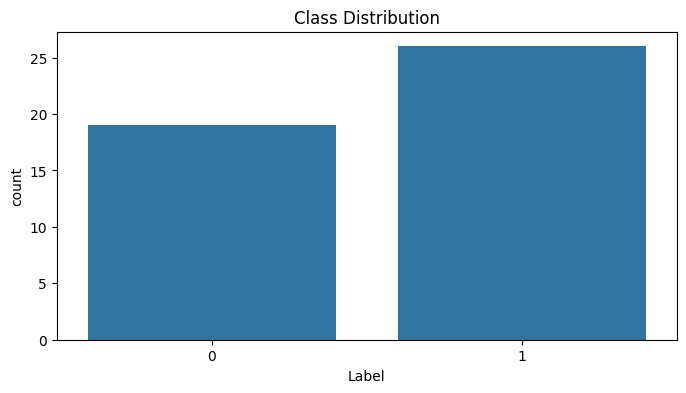

Processing all 45 patients...
Motion thresh: 1.5
filter band max: 3.0
Window: 6000, Stride: 3000
  > Processed ppg\001_PPG.mat: 1648 accepted / 4287 total
    - Rejected Flatlines:  0
    - Rejected Motion:     0
    - Rejected Low SNR:    2639
    - Rejected Low Beats:  0
   > Patient 1: 1648/4287 windows ( 38.4% Clean) [Total: 1648]
Motion thresh: 1.5
filter band max: 3.0
Window: 6000, Stride: 3000
  > Processed ppg\002_PPG.mat: 183 accepted / 2669 total
    - Rejected Flatlines:  0
    - Rejected Motion:     0
    - Rejected Low SNR:    2486
    - Rejected Low Beats:  0
   > Patient 2: 183/2669 windows (  6.9% Clean) [Total: 1831]
Motion thresh: 1.5
filter band max: 3.0
Window: 6000, Stride: 3000
  > Processed ppg\003_PPG.mat: 805 accepted / 2600 total
    - Rejected Flatlines:  13
    - Rejected Motion:     0
    - Rejected Low SNR:    1776
    - Rejected Low Beats:  6
   > Patient 3: 805/2600 windows ( 31.0% Clean) [Total: 2636]
Motion thresh: 1.5
filter band max: 3.0
Window: 6000

    [LSTM]       Acc: 0.9813 | F1: 0.9808 | Lat: 60.68ms

>>> PROCESSING FOLD 2 <<<
[Fold 2]
   TRAIN: Total=9158, Risk Count=4452 (48.6%)
   TEST:  Total=4569,  Risk Count=2235  (48.9%)
   Train Shape: (9158, 27) | Test Shape: (4569, 27)
 -> Selected 27 / 35 features.
    -> [Optimized] Best LogReg Params: {'penalty': 'l2', 'C': 10}
    [LogReg] Acc: 0.4977 | F1: 0.5501 | Lat: 0.12ms
    -> [Optimized] Best DecisionTree Params: {'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}
    [DecisionTree] Acc: 0.5850 | F1: 0.6435 | Lat: 0.11ms
    -> [Optimized] Best RandomForest Params: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': 'balanced'}
    [RandomForest] Acc: 0.5443 | F1: 0.6208 | Lat: 44.71ms
    -> [Optimized] Best XGBoost Params: {'scale_pos_weight': 10, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
    [XGBoost] Acc: 0.5850 | F1: 0.6435 | Lat: 0.55ms
    -> Optimizing MSRF (Manual Search)...
       Best MSRF Params: {'n_e

    [LSTM]       Acc: 0.5262 | F1: 0.5715 | Lat: 59.90ms

>>> PROCESSING FOLD 3 <<<
[Fold 3]
   TRAIN: Total=9169, Risk Count=4461 (48.7%)
   TEST:  Total=4558,  Risk Count=2226  (48.8%)
   Train Shape: (9169, 27) | Test Shape: (4558, 27)
 -> Selected 27 / 35 features.
    -> [Optimized] Best LogReg Params: {'penalty': 'l2', 'C': 10}
    [LogReg] Acc: 0.5937 | F1: 0.4034 | Lat: 0.15ms
    -> [Optimized] Best DecisionTree Params: {'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}
    [DecisionTree] Acc: 0.6125 | F1: 0.4214 | Lat: 0.11ms
    -> [Optimized] Best RandomForest Params: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': None, 'class_weight': 'balanced'}
    [RandomForest] Acc: 0.6345 | F1: 0.4758 | Lat: 53.65ms
    -> [Optimized] Best XGBoost Params: {'scale_pos_weight': 10, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01}
    [XGBoost] Acc: 0.4884 | F1: 0.6562 | Lat: 0.53ms
    -> Optimizing MSRF (Manual Search)...
       Best MSRF Params: {'n_e

    [LSTM]       Acc: 0.5720 | F1: 0.3228 | Lat: 63.42ms

FINAL BENCHMARK RESULTS (Mean ± SD across 3 Folds)
       Model        Accuracy       Precision          Recall        F1-Score     Specificity             MCC          PR-AUC     Brier Score  Latency (ms)  Size (KB)  Inf RAM (KB)
DecisionTree 0.6753 ± 0.1332 0.7004 ± 0.1261 0.6596 ± 0.3308 0.6346 ± 0.2089 0.6906 ± 0.2580 0.3780 ± 0.2575 0.7641 ± 0.0870 0.3240 ± 0.1327          0.11       2.92          2.51
        LSTM 0.6931 ± 0.2506 0.7328 ± 0.2326 0.6135 ± 0.3894 0.6250 ± 0.3322 0.7690 ± 0.3112 0.4011 ± 0.4902 0.8377 ± 0.1567 0.2475 ± 0.2202         61.34     331.35        113.66
      LogReg 0.6851 ± 0.2462 0.7326 ± 0.2534 0.6130 ± 0.3246 0.6383 ± 0.2893 0.7536 ± 0.3336 0.3833 ± 0.4855 0.8036 ± 0.1619 0.3012 ± 0.2374          0.12       0.94          2.20
        MSRF 0.7313 ± 0.2111 0.7682 ± 0.2010 0.6999 ± 0.3300 0.6982 ± 0.2517 0.7612 ± 0.3028 0.4845 ± 0.4060 0.7775 ± 0.2115 0.2219 ± 0.1408        137.75    8474.08      

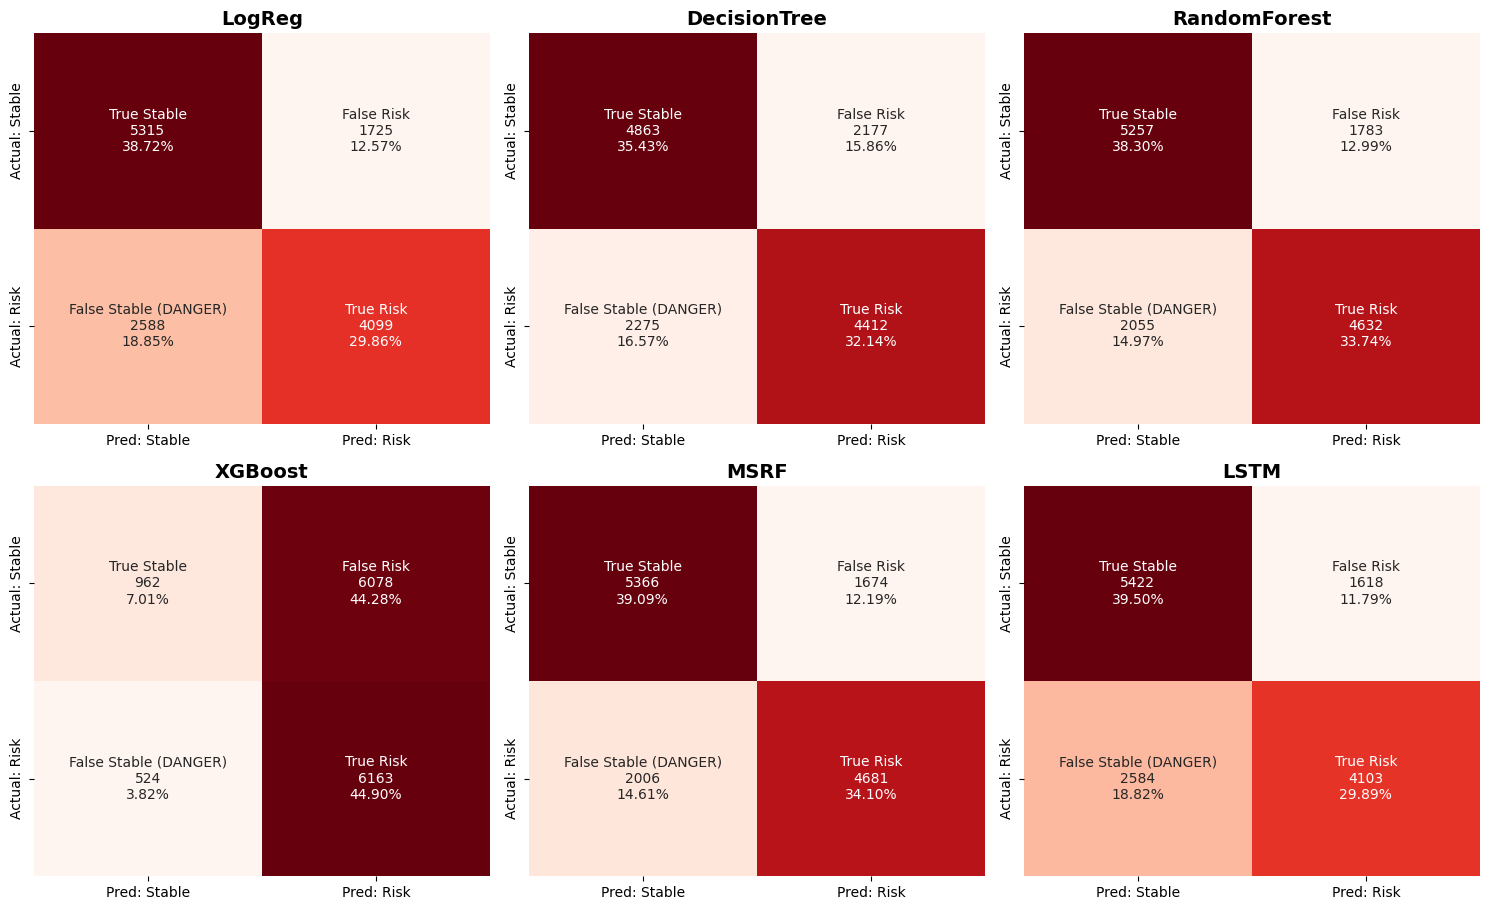

[SAVED] Confusion matrices plot saved to: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\confusion_matrices.png


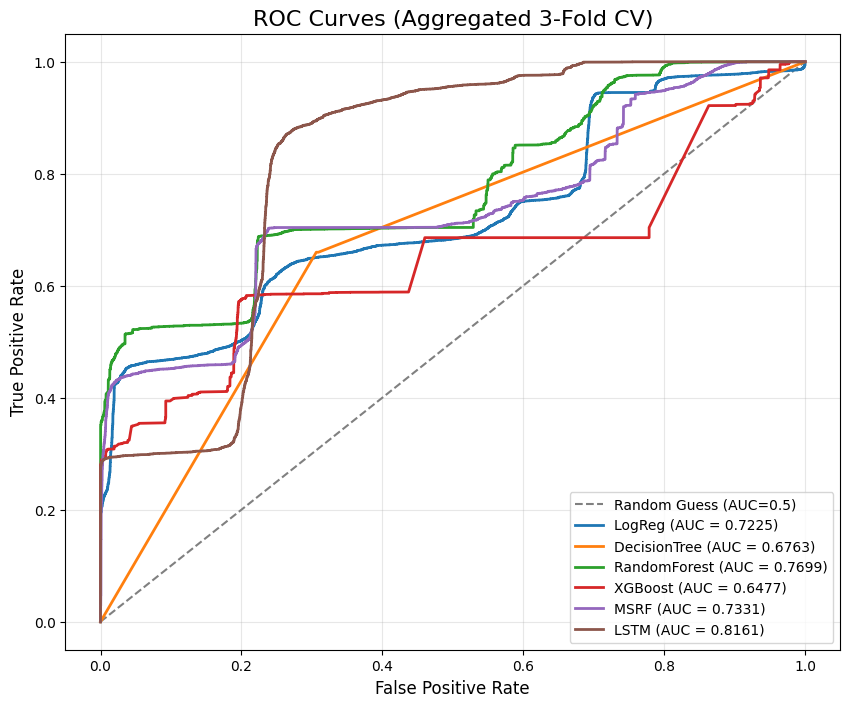

[SAVED] ROC Curves plot saved to: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\roc_curves.png


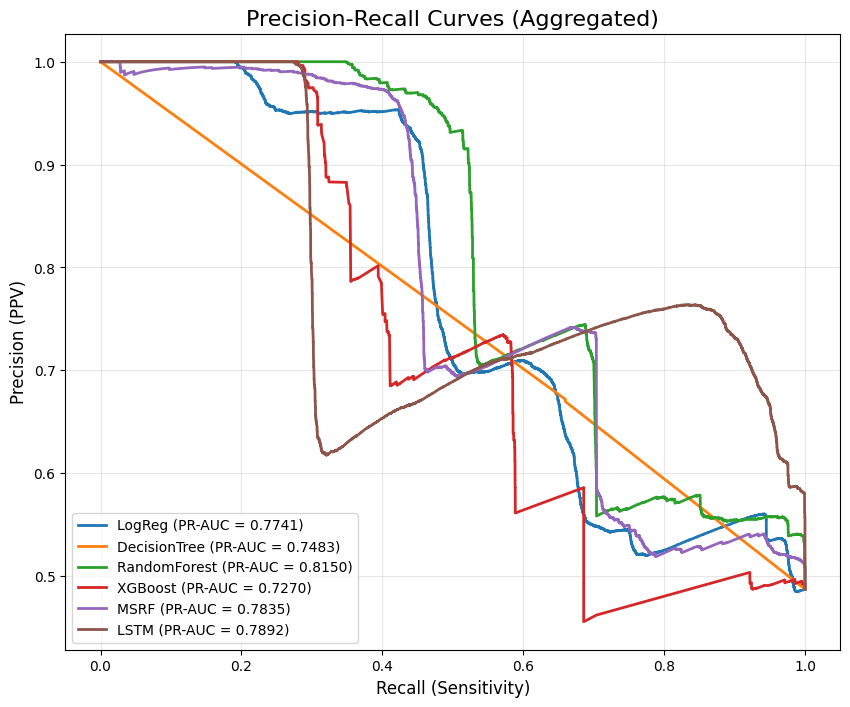

Log file closed. Output reset to terminal.


In [ ]:
# ==========================================
# CELL 6: MAIN EXECUTION LOOP
# ==========================================
# Experiment Constants
WINDOW_SEC = 60     # Window size in seconds
STRIDE_SEC = 30      # Stride in seconds
FS_PPG     = 100     # Sampling Rate

SNR_THRESH    = 5.0  # Signal Quality: Min SNR (dB)
MOTION_THRESH = 1.5  # Signal Quality: Max Motion (g)
TAU      = 2  # Clinical: Min Risk Factors for Class 1
FILTER_BAND_MAX = 3.0
DATA_PER_PATIENT_FRACTION = 1
CLEAN_PERCENTAGE = 0
MEDICAL_THRESHOLD = 0.5

CORR_THRESH       = 0.90  # Feature correlation filtering
P_VALUE_THRESH    = 0.05  # Feature significance filtering
N_FOLDS           = 3     # Cross-validation folds
MSRF_MODE = 'confidence'

# --- Directory Setup ---
EXPERIMENT_NAME = "Exp_01_Baseline" 
MAIN_RESULTS_DIR = "Thesis_Experiments"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

run_folder_name = (
    f"Run_{timestamp}_"
    f"Win{WINDOW_SEC}_Stride{STRIDE_SEC}_"
    f"SNR{int(SNR_THRESH)}_Tau{TAU}_"
    f"Filter_band{FILTER_BAND_MAX}_"
    f"Mode{MSRF_MODE}_"
    f"Restrict{CLEAN_PERCENTAGE}"
)

output_dir = os.path.join(MAIN_RESULTS_DIR, EXPERIMENT_NAME, run_folder_name)
os.makedirs(output_dir, exist_ok=True)

# --- Dual Logger Class ---
class DualLogger(object):
    def __init__(self, filepath):
        self.terminal = sys.stdout
        self.log = open(filepath, "w", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# Initialize Logger
log_file_path = os.path.join(output_dir, "execution_log.txt")
sys.stdout = DualLogger(log_file_path)

print(f"=== EXPERIMENT EXECUTION STARTED ===")
print(f"Output Directory: {output_dir}")
print("="*40)
print(f" [Phase 1] View:      Window={WINDOW_SEC}s, Stride={STRIDE_SEC}s, Fs={FS_PPG}Hz")
print(f" [Phase 2] Quality:   SNR>{SNR_THRESH}dB, Motion<{MOTION_THRESH}g")
print(f" [Phase 3] Clinical:  Tau (Risk Factors) >= {TAU}")
print(f" [Phase 4] Model:     P_Val<{P_VALUE_THRESH}")
print(f" [Phase 5] MSRF mode: Mode={MSRF_MODE}")
print("="*40)

# 1. DATA LOADING
print(f"--- Loading Data ({DATA_PER_PATIENT_FRACTION * 100}% Data Per Patient) ---")
mgr = ClinicalDataManager(BASE_DIR, STATIC_FILE)
mgr.analyze_demographics(TAU)

all_ids = mgr.df['ID'].unique()
print(f"Processing all {len(all_ids)} patients...")

X_list = []
y_list = []
groups = [] 

expected_dynamic = ["HR", "SDNN", "RMSSD", "pNN50", "CV_IBI", "PPG_Amp", 
                    "RiseTime", "FallTime", "Width", "Area", "SampEn", 
                    "TPR", "SNR", "MotionVM"]
expected_static = mgr.get_static_feature_names()
FULL_FEATURE_NAMES = expected_dynamic + expected_static

processed_count = 0
window_counts = {}
total_windows_accumulated = 0
dropped_patients = 0

for pid in all_ids:
    # Try different file naming conventions
    fpath = os.path.join(BASE_DIR, f"{int(pid):03d}_PPG.mat")
    if not os.path.exists(fpath): 
        fpath = os.path.join(BASE_DIR, f"{int(pid)}_PPG.mat")
    if not os.path.exists(fpath): continue 
        
    label, statics = mgr.get_patient_data(pid, TAU)
    if label is None: continue
    
    try:
        # Extract features (returns tuple: valid_features, valid_labels, valid_groups, total_potential_windows)
        feats, _, _, n_potential = FeatureExtractor.process_file(fpath, statics, WINDOW_SEC, STRIDE_SEC, SNR_THRESH, MOTION_THRESH, FILTER_BAND_MAX, fs=FS_PPG)
    except OSError: continue
    
    # Calculate Yield First
    n_actual = len(feats)
    if n_potential > 0:
        yield_pct = (n_actual / n_potential) * 100
    else:
        yield_pct = 0.0

    # Filter: Only keep patients with > 20% Clean Data
    if yield_pct < CLEAN_PERCENTAGE:
        print(f"   x Dropped Patient {pid}: Low Yield ({yield_pct:.1f}% < 20%)")
        dropped_patients += 1
        continue
    
    if n_actual > 0:
        total_windows_accumulated += n_actual
        X_list.extend(feats)
        y_list.extend([label] * n_actual)
        groups.extend([pid] * n_actual)
        processed_count += 1
        
        print(f"   > Patient {pid}: {n_actual:3d}/{n_potential:<3d} windows ({yield_pct:5.1f}% Clean) [Total: {total_windows_accumulated}]")

if not X_list: sys.exit("Stopping: No data loaded.")

X_all = np.array(X_list)
y_all = np.array(y_list)
groups = np.array(groups)

print(f"\n[Data Loaded] Total Windows: {X_all.shape[0]} | Features: {X_all.shape[1]}")

# 2. HYPERPARAMETER GRIDS & SETTINGS
param_grids = {
    "LogReg": {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
    "DecisionTree": {'max_depth': [3, 5, 10, None], 'min_samples_leaf': [2, 5, 10], 'criterion': ['gini', 'entropy']},
    "RandomForest": {'n_estimators': [50, 100, 200, 300], 'max_depth': [5, 10, None], 'min_samples_leaf': [2, 5], 'class_weight': ['balanced']},
    "XGBoost": {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7], 'scale_pos_weight': [1, 5, 10]} 
    # scale_pos_weight helps XGBoost handle class imbalance (like class_weight)
}

msrf_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [2, 5],
    'class_weight': ['balanced']
}

# 3. CROSS VALIDATION LOOP
gkf = StratifiedGroupKFold(n_splits=N_FOLDS)
print(f"\n[Starting {N_FOLDS}-Fold CV")

model_names = ["LogReg", "DecisionTree", "RandomForest", "XGBoost", "MSRF", "LSTM"]
conf_matrix_data = {name: {'true': [], 'pred': []} for name in model_names}
raw_results = {name: {'y_true': [], 'y_prob': []} for name in model_names}
fold_results = []

# Helper for Dynamic Thresholding
def get_optimal_threshold(y_true_train, y_prob_train):
    """
    Finds threshold maximizing F1 on TRAINING data, 
    but with a Safety Cap to prevent overfitting.
    """
    prec, rec, threshs = precision_recall_curve(y_true_train, y_prob_train)
    
    # Calculate F1 for all possible thresholds
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-10)
    best_idx = np.argmax(f1_scores)
    
    optimal_thresh = 0.5 # Default
    if best_idx < len(threshs):
        optimal_thresh = threshs[best_idx]
        
    # If the threshold is too high (overfit) or too low (noise), 
    # force it back to a conservative 0.5 or a max cap (0.8).
    if optimal_thresh > 0.8 or optimal_thresh < 0.15:
        print(f"      [Warning] Calculated threshold {optimal_thresh:.3f} is extreme. Reverting to 0.50.")
        return 0.5
        
    return optimal_thresh

print(f"\n[Data Loaded] Total Windows: {X_all.shape[0]} | Features: {X_all.shape[1]}")

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups)):
    print(f"\n>>> PROCESSING FOLD {fold + 1} <<<")
    
    # Split
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Data Cleaning Stats
    train_risk = np.sum(y_train == 1)
    train_total = len(y_train)
    test_risk = np.sum(y_test == 1)
    test_total = len(y_test)
    
    print(f"[Fold {fold+1}]")
    print(f"   TRAIN: Total={train_total}, Risk Count={train_risk} ({train_risk/train_total:.1%})")
    print(f"   TEST:  Total={test_total},  Risk Count={test_risk}  ({test_risk/test_total:.1%})")
    
    if test_risk == 0:
        print("   >>> WARNING: Test set has ZERO risk samples. F1 Score will be 0.0!")
    
    # Select Features
    selector = StatisticalFeatureSelector(
        feature_names=FULL_FEATURE_NAMES, corr_threshold=CORR_THRESH, p_threshold=P_VALUE_THRESH, verbose=False
    )
    X_train_sel = selector.fit_transform(X_train_scaled, y_train)
    X_test_sel = selector.transform(X_test_scaled)

    # RESTORED FEATURE REPORT
    print(f"   Train Shape: {X_train_sel.shape} | Test Shape: {X_test_sel.shape}")
    print(f" -> Selected {X_train_sel.shape[1]} / {len(FULL_FEATURE_NAMES)} features.")
    
    # MSRF Data Prep
    groups_train = groups[train_idx]
    unique_train_groups = np.unique(groups_train)
    X_train_seq = []
    y_train_seq = []
    for pid in unique_train_groups:
        mask = (groups_train == pid)
        X_train_seq.append(X_train_sel[mask])
        y_train_seq.append(y_train[mask])

    # Define Base Models
    base_models = {
        "LogReg": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
        "MSRF": MSRF_Classifier(n_states=3, n_estimators=50, verbose=True, random_state=42,mode=MSRF_MODE) 
    }
    
    for name, model in base_models.items():
        # Train
        if name == "MSRF":
            # model.fit(X_train_seq, y_train_seq)
            # best_model = model
            # if hasattr(model, "predict_proba"):
            #      # Handle MSRF Proba if implemented
            #      pass
                
            # --- MANUAL RANDOM SEARCH FOR MSRF ---
            print(f"    -> Optimizing MSRF (Manual Search)...")
            
            # A. Create a mini validation split (20% of patients) for tuning
            #    We cannot use standard CV because MSRF needs 'List of Arrays'
            tuning_pids = np.unique(groups_train)
            np.random.shuffle(tuning_pids)
            
            split_idx = int(len(tuning_pids) * 0.8)
            t_train_ids = tuning_pids[:split_idx] # 80% for mini-training
            t_val_ids = tuning_pids[split_idx:]   # 20% for mini-validation
            
            # Helper: specific function to build lists for MSRF
            def get_seq_data(pids, X_src, y_src, g_src):
                X_s, y_s = [], []
                for pid in pids:
                    mask = (g_src == pid)
                    X_s.append(X_src[mask])
                    y_s.append(y_src[mask])
                return X_s, y_s

            X_t_train, y_t_train = get_seq_data(t_train_ids, X_train_sel, y_train, groups_train)
            X_t_val, y_t_val = get_seq_data(t_val_ids, X_train_sel, y_train, groups_train)

            # B. Search Loop (Try 3 Random Configs)
            best_score = -1
            best_params = {}
            n_iter_search = 10
            
            for i in range(n_iter_search):
                # Pick random params
                curr_params = {
                    'n_estimators': random.choice(msrf_grid['n_estimators']),
                    'max_depth': random.choice(msrf_grid['max_depth']),
                    'min_samples_leaf': random.choice(msrf_grid['min_samples_leaf']),
                    'class_weight': 'balanced'
                }
                
                # Train Temp Model
                tmp_model = MSRF_Classifier(n_states=3, rf_params=curr_params, verbose=False)
                
                try:
                    tmp_model.fit(X_t_train, y_t_train)
                    
                    # Score it
                    y_pred_val = tmp_model.predict(X_t_val)
                    y_true_val_flat = np.concatenate(y_t_val) # Flatten for scoring
                    score = f1_score(y_true_val_flat, y_pred_val, zero_division=0)
                except Exception as e:
                    score = 0
                
                if score > best_score:
                    best_score = score
                    best_params = curr_params
            
            print(f"       Best MSRF Params: {best_params} (F1: {best_score:.4f})")
            
            # C. Train FINAL model on FULL training set using winner params
            best_model = MSRF_Classifier(n_states=3, rf_params=best_params, verbose=True)
            best_model.fit(X_train_seq, y_train_seq)

        elif name in param_grids:
            # Optimize for F1-Score
            search = RandomizedSearchCV(model, param_grids[name], n_iter=10, cv=3, scoring='f1', n_jobs=-1, random_state=None)
            search.fit(X_train_sel, y_train)
            print(f"    -> [Optimized] Best {name} Params: {search.best_params_}")
            best_model = search.best_estimator_
        else:
            model.fit(X_train_sel, y_train)
            best_model = model
        
        # Predict with MEDICAL THRESHOLD
        if hasattr(best_model, "predict_proba"):
            y_prob = best_model.predict_proba(X_test_sel)[:, 1]
            y_pred = (y_prob > MEDICAL_THRESHOLD).astype(int)
        else:
            y_pred = best_model.predict(X_test_sel)
            y_prob = y_pred
            
        conf_matrix_data[name]['true'].extend(y_test)
        conf_matrix_data[name]['pred'].extend(y_pred)

        raw_results[name]['y_true'].extend(y_test)
        raw_results[name]['y_prob'].extend(y_prob)
        
        perf = calculate_metrics(y_test, y_pred, y_prob)
        # Resource Metrics (only measure on first fold to save time, or measure once per model type)
        smart_metrics = measure_smartphone_metrics(name, best_model, X_test_sel[0].reshape(1,-1))

        fold_results.append({**perf, **smart_metrics, "Fold": fold+1, "Model": name})
        print(f"    [{name}] Acc: {perf['Accuracy']:.4f} | F1: {perf['F1-Score']:.4f} | Lat: {smart_metrics['Latency (ms)']:.2f}ms")
        
    # LSTM Training
    print("    [LSTM] Training...")
    X_train_lstm = X_train_sel.reshape((X_train_sel.shape[0], 1, X_train_sel.shape[1]))
    X_test_lstm = X_test_sel.reshape((X_test_sel.shape[0], 1, X_test_sel.shape[1]))

    lstm_model = Sequential([
        LSTM(64, input_shape=(1, X_train_sel.shape[1])),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=64, verbose=0) # Fast epochs for testing
    
    # LSTM Dynamic Thresholding
    y_train_prob_lstm = lstm_model.predict(X_train_lstm, verbose=0).flatten()
    # lstm_thresh = get_optimal_threshold(y_train, y_train_prob_lstm)
    # print(f"    [LSTM] Tuned Threshold: {lstm_thresh:.3f}")

    y_prob_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()
    y_pred_lstm = (y_prob_lstm > MEDICAL_THRESHOLD).astype(int)

    conf_matrix_data["LSTM"]['true'].extend(y_test)
    conf_matrix_data["LSTM"]['pred'].extend(y_pred_lstm)
    raw_results["LSTM"]['y_true'].extend(y_test)
    raw_results["LSTM"]['y_prob'].extend(y_prob_lstm)

    perf_lstm = calculate_metrics(y_test, y_pred_lstm, y_prob_lstm)
    smart_lstm = measure_smartphone_metrics("LSTM", lstm_model, X_test_lstm[0:1])
    fold_results.append({**perf_lstm, **smart_lstm, "Fold": fold+1, "Model": "LSTM"})
        
    print(f"    [LSTM]       Acc: {perf_lstm['Accuracy']:.4f} | F1: {perf_lstm['F1-Score']:.4f} | Lat: {smart_lstm['Latency (ms)']:.2f}ms")

# 4. RESULTS
df_all = pd.DataFrame(fold_results)

perf_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "MCC", "PR-AUC", "Brier Score"]
smart_cols = ["Latency (ms)", "Size (KB)", "Inf RAM (KB)"]

# AGGREGATION: MEAN +- STD
# Group by Model to get Mean and Standard Deviation
grouped = df_all.groupby("Model")[perf_cols]
df_mean = grouped.mean()
df_std = grouped.std().fillna(0) # Fill NaN with 0 if only 1 fold

# Create a container for the formatted results
df_final_formatted = pd.DataFrame()
df_final_formatted["Model"] = df_mean.index

# Format loop: Combine Mean and STD into strings
for col in perf_cols:
    m_vals = df_mean[col].values
    s_vals = df_std[col].values
    
    # Create the "Mean +- SD" string list
    formatted_col = [f"{m:.4f} ± {s:.4f}" for m, s in zip(m_vals, s_vals)]
    df_final_formatted[col] = formatted_col

df_smart_avg = df_all.groupby("Model")[smart_cols].mean().reset_index()

df_smart_avg["Latency (ms)"] = df_smart_avg["Latency (ms)"].round(2)
df_smart_avg["Size (KB)"] = df_smart_avg["Size (KB)"].round(2)
df_smart_avg["Inf RAM (KB)"] = df_smart_avg["Inf RAM (KB)"].round(2)

final_df = pd.merge(df_final_formatted, df_smart_avg, on="Model")

# Reorder columns (Performance first, then Resources)
cols_order = ["Model"] + perf_cols + smart_cols
final_df = final_df[cols_order]

print("\n" + "="*80)
print(f"FINAL BENCHMARK RESULTS (Mean ± SD across {N_FOLDS} Folds)")
print("="*80)
# to_string ensures the full table prints without truncating
print(final_df.to_string(index=False))

# Save CSV
csv_path = os.path.join(output_dir, "benchmark_results_with_sd.csv")
final_df.to_csv(csv_path, index=False)
print(f"\n[SAVED] Benchmark metrics saved to: {csv_path}")

# Plot Confusion Matrices
n_models = len(conf_matrix_data)
cols = 3
rows = math.ceil(n_models / cols)
plt.figure(figsize=(15, 5 * rows))

for i, (name, data) in enumerate(conf_matrix_data.items()):
    plt.subplot(rows, cols, i + 1)
    cm = confusion_matrix(data['true'], data['pred'], labels=[0, 1])
    group_names = ['True Stable','False Risk','False Stable (DANGER)','True Risk']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Reds', cbar=False,
                xticklabels=['Pred: Stable', 'Pred: Risk'], yticklabels=['Actual: Stable', 'Actual: Risk'])
    plt.title(f"{name}", fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save Plot
img_path = os.path.join(output_dir, "confusion_matrices.png")
plt.savefig(img_path)
plt.show()
print(f"[SAVED] Confusion matrices plot saved to: {img_path}")

plt.figure(figsize=(10, 8))
plt.title(f"ROC Curves (Aggregated {N_FOLDS}-Fold CV)", fontsize=16)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC=0.5)')

for name, data in raw_results.items():
    # Only plot if we have data
    if len(data['y_true']) > 0:
        fpr, tpr, _ = roc_curve(data['y_true'], data['y_prob'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.4f})")

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Save ROC Plot
roc_path = os.path.join(output_dir, "roc_curves.png")
plt.savefig(roc_path)
plt.show()
print(f"[SAVED] ROC Curves plot saved to: {roc_path}")

#PR-AUC plot
plt.figure(figsize=(10, 8))
plt.title(f"Precision-Recall Curves (Aggregated)", fontsize=16)
for name, data in raw_results.items():
    if len(data['y_true']) > 0:
        precision, recall, _ = precision_recall_curve(data['y_true'], data['y_prob'])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f"{name} (PR-AUC = {pr_auc:.4f})")
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (PPV)', fontsize=12)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, "pr_curves.png"))
plt.show()

#Close Logger
try:
    sys.stdout.log.close()
    sys.stdout = sys.stdout.terminal
    print("Log file closed. Output reset to terminal.")
except:
    pass


--- 3. Running Bootstrap on ALL Metrics (N=1000) ---

[SAVED] Master Bootstrap Table: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\bootstrap_results_all_metrics.csv
       Model             Accuracy            Precision               Recall             F1-Score          Specificity                  MCC               PR-AUC          Brier Score
      LogReg 0.686 [0.679, 0.694] 0.704 [0.693, 0.716] 0.613 [0.602, 0.625] 0.655 [0.646, 0.665] 0.755 [0.745, 0.765] 0.372 [0.358, 0.388] 0.774 [0.765, 0.783] 0.301 [0.293, 0.307]
DecisionTree 0.676 [0.668, 0.684] 0.670 [0.659, 0.681] 0.660 [0.648, 0.671] 0.665 [0.656, 0.674] 0.691 [0.681, 0.702] 0.351 [0.335, 0.367] 0.609 [0.599, 0.620] 0.324 [0.316, 0.331]
RandomForest 0.720 [0.713, 0.728] 0.722 [0.710, 0.732] 0.693 [0.682, 0.704] 0.707 [0.698, 0.715] 0.746 [0.736, 0.757] 0.440 [0.425, 0.455] 0.815 [0.808, 0.822] 0.194 [0.190, 0.197]
     XGBoost 0.519 [0.511, 0.52

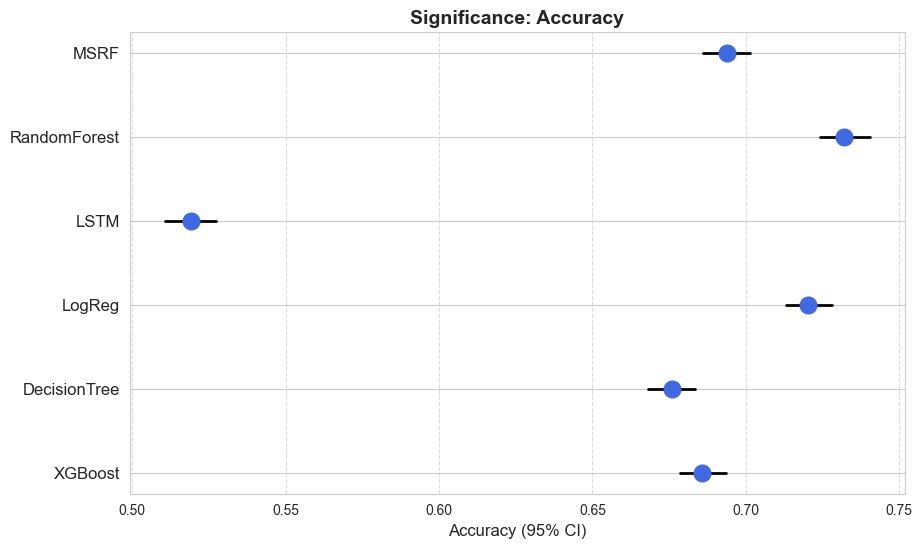

   > Saved Forest Plot: forest_plot_Accuracy.png


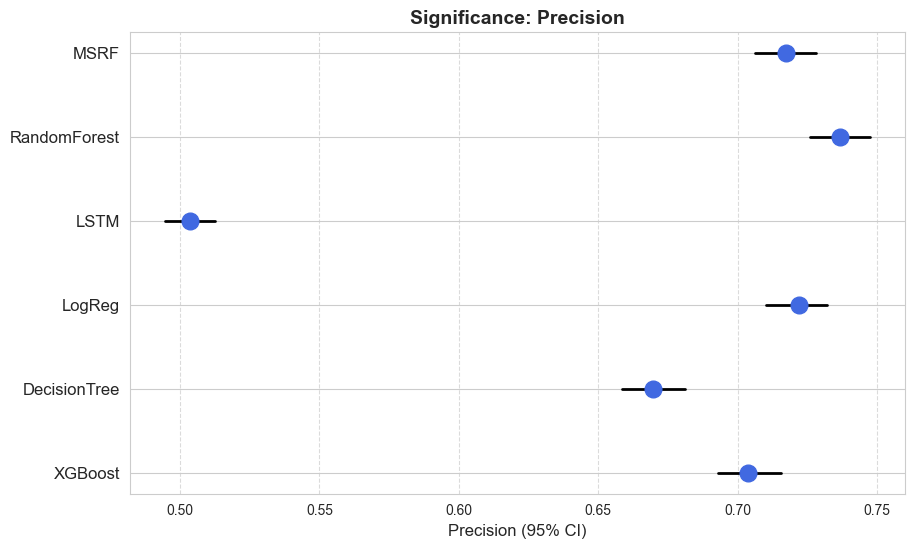

   > Saved Forest Plot: forest_plot_Precision.png


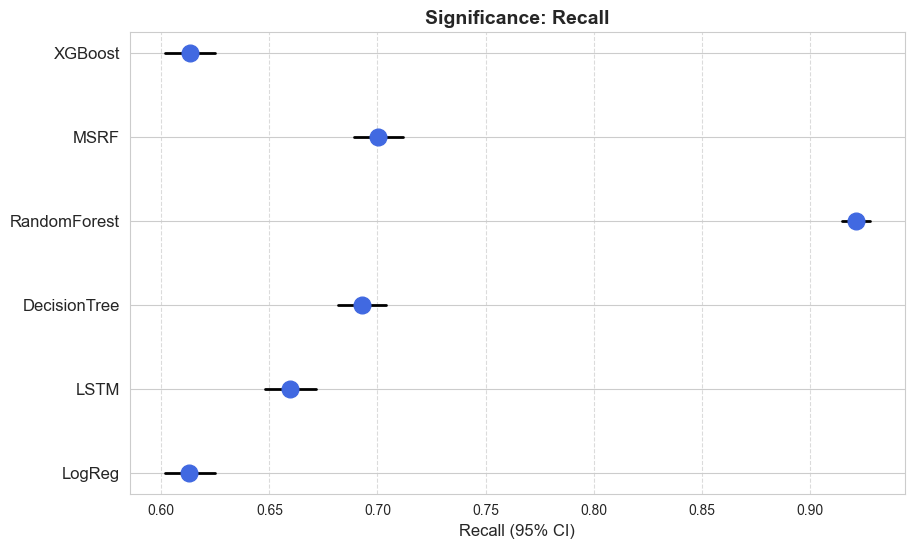

   > Saved Forest Plot: forest_plot_Recall.png


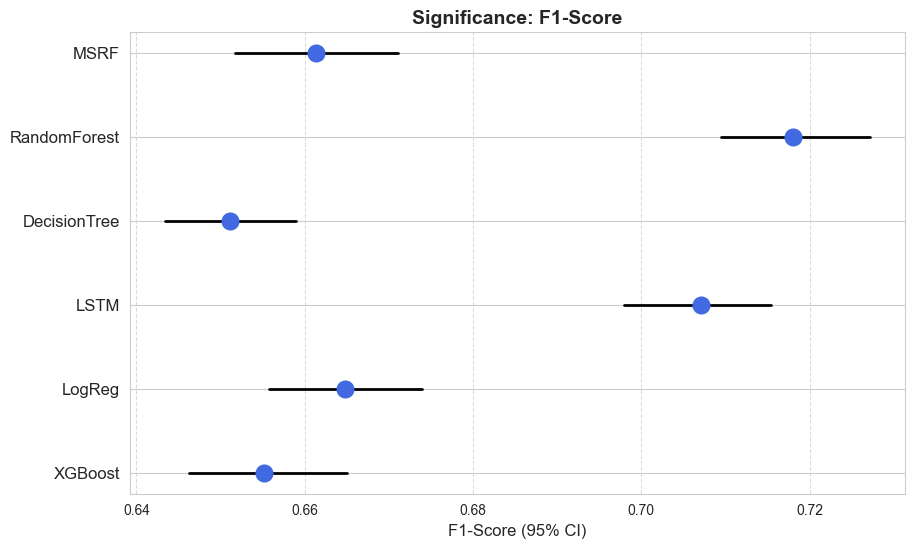

   > Saved Forest Plot: forest_plot_F1-Score.png


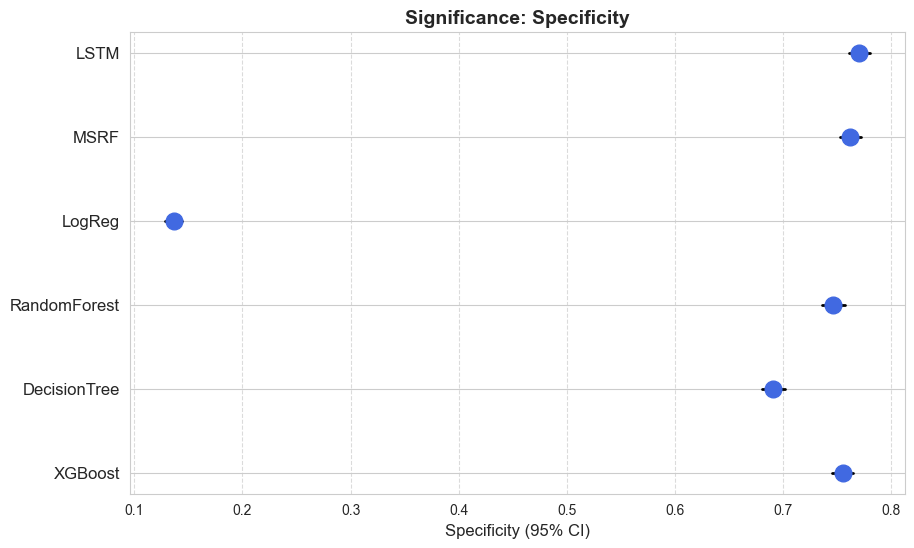

   > Saved Forest Plot: forest_plot_Specificity.png


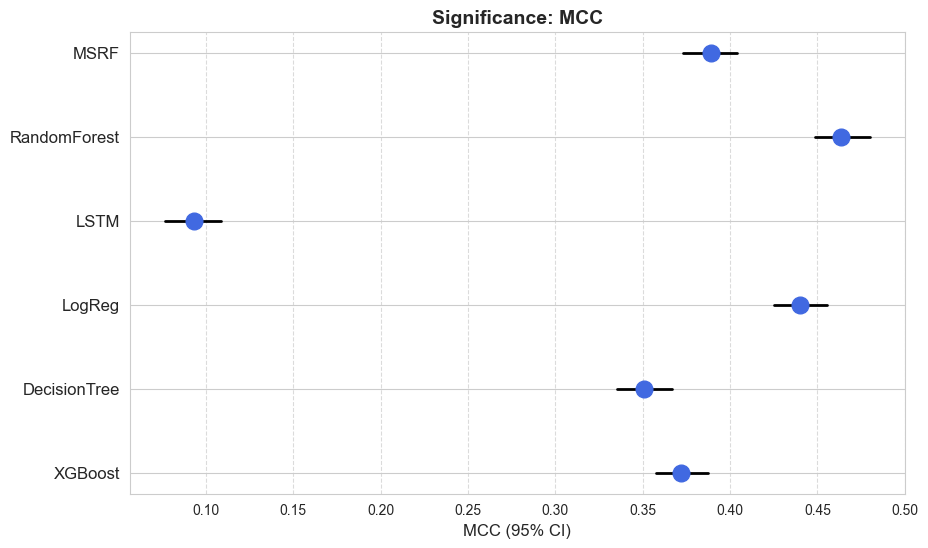

   > Saved Forest Plot: forest_plot_MCC.png


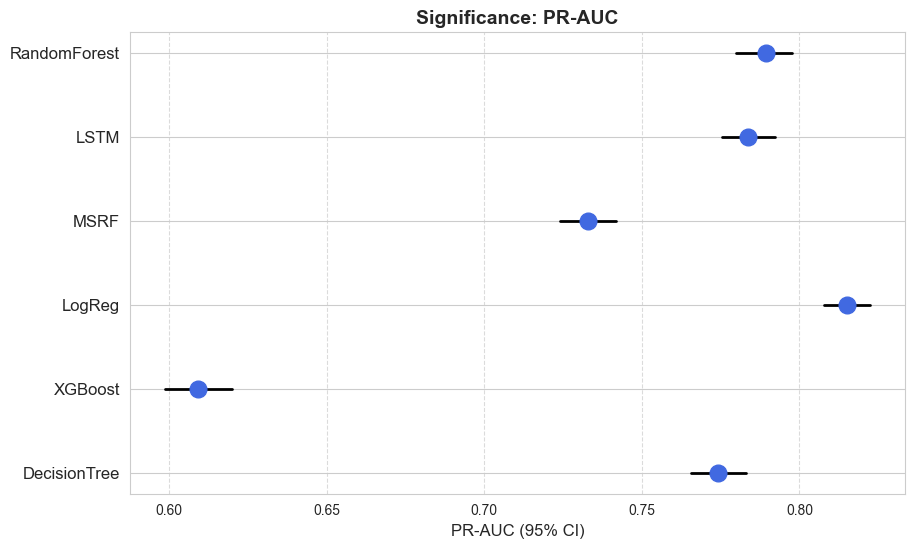

   > Saved Forest Plot: forest_plot_PR-AUC.png


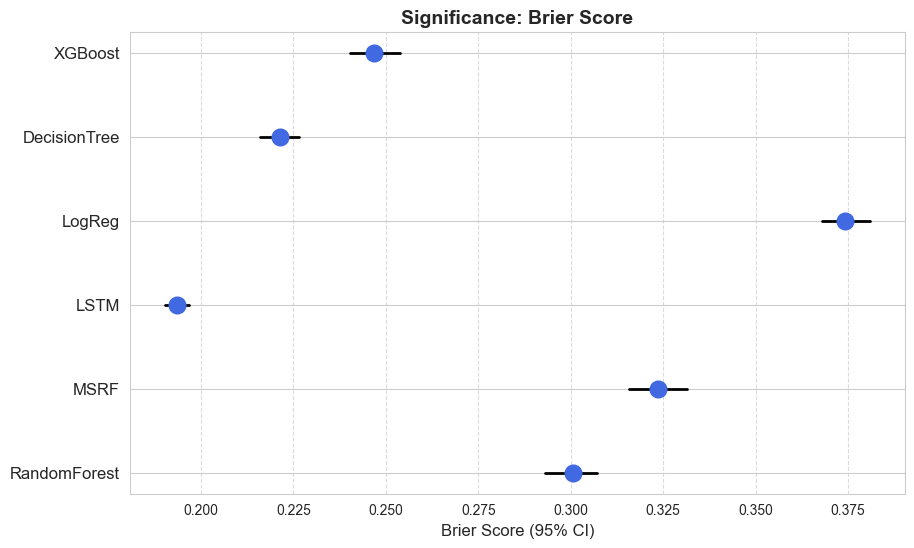

   > Saved Forest Plot: forest_plot_BrierScore.png

=== BOOTSTRAP COMPLETE ===


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from sklearn.utils import resample
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                             recall_score, matthews_corrcoef, confusion_matrix,
                             average_precision_score, brier_score_loss)

# DEFINE HELPER FUNCTION
def calc_specificity(y_true, y_pred):
    # Handle edge case where confusion matrix is not 2x2
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        return tn / (tn + fp + 1e-10)
    except ValueError:
        return 0.0

metrics_list = ["Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "MCC", "PR-AUC", "Brier Score"]

print("\n--- 3. Running Bootstrap on ALL Metrics (N=1000) ---")

forest_dir = os.path.join(output_dir, "Significance_Forest_Plots")
os.makedirs(forest_dir, exist_ok=True)

n_iterations = 1000
alpha = 0.95 

# Storage for the final table
bootstrap_summary = [] 
# Storage for plotting data
plot_data_storage = {m: [] for m in metrics_list}

# Bootstrap loop
for name, data in raw_results.items():
    if len(data['y_true']) == 0: continue

    y_true_all = np.array(data['y_true'])
    y_prob_all = np.array(data['y_prob'])
    
    # Pre-calculate binary preds for efficiency (using 0.5 threshold)
    y_pred_all = (y_prob_all > 0.5).astype(int)

    # Dictionaries to hold scores for this model
    model_scores = {m: [] for m in metrics_list}
    
    for i in range(n_iterations):
        # Resample indices
        indices = resample(range(len(y_true_all)), replace=True)
        
        y_t_boot = y_true_all[indices]
        y_p_boot = y_pred_all[indices]
        y_prob_boot = y_prob_all[indices]
        
        if len(np.unique(y_t_boot)) < 2: continue 

        # Calculate all metrics for this iteration
        try:
            # Binary Metrics
            model_scores["Accuracy"].append(accuracy_score(y_t_boot, y_p_boot))
            model_scores["F1-Score"].append(f1_score(y_t_boot, y_p_boot, zero_division=0))
            model_scores["Recall"].append(recall_score(y_t_boot, y_p_boot, zero_division=0))
            model_scores["Precision"].append(precision_score(y_t_boot, y_p_boot, zero_division=0))
            model_scores["MCC"].append(matthews_corrcoef(y_t_boot, y_p_boot))
            model_scores["Specificity"].append(calc_specificity(y_t_boot, y_p_boot))
            
            # Probability Metrics
            model_scores["PR-AUC"].append(average_precision_score(y_t_boot, y_prob_boot))
            model_scores["Brier Score"].append(brier_score_loss(y_t_boot, y_prob_boot))
        except:
            continue

    # Process results for this model
    row_entry = {"Model": name}
    
    for metric in metrics_list:
        scores = np.array(model_scores[metric])
        if len(scores) == 0: continue

        lower = np.percentile(scores, ((1.0 - alpha) / 2.0) * 100)
        upper = np.percentile(scores, (alpha + ((1.0 - alpha) / 2.0)) * 100)
        mean_score = np.mean(scores)
        
        # 1. Add to Table Data (String Format)
        row_entry[metric] = f"{mean_score:.3f} [{lower:.3f}, {upper:.3f}]"
        
        # 2. Add to Plot Data (Raw Numbers)
        plot_data_storage[metric].append({
            "Model": name, "Mean": mean_score, "Lower": lower, "Upper": upper
        })

    bootstrap_summary.append(row_entry)

df_boot_table = pd.DataFrame(bootstrap_summary)
# Reorder columns
cols_ordered = ["Model"] + [m for m in metrics_list if m in df_boot_table.columns]
df_boot_table = df_boot_table[cols_ordered]

csv_path = os.path.join(output_dir, "bootstrap_results_all_metrics.csv")
df_boot_table.to_csv(csv_path, index=False)
print(f"\n[SAVED] Master Bootstrap Table: {csv_path}")
print(df_boot_table.to_string(index=False))

# generate forest plot
print("\n--- Generating Forest Plots ---")
for metric, stats in plot_data_storage.items():
    if not stats: continue
    
    df_plot = pd.DataFrame(stats).sort_values("Mean", ascending=True)
    
    plt.figure(figsize=(10, 6))
    for i, row in df_plot.iterrows():
        # Line (Interval)
        plt.plot([row["Lower"], row["Upper"]], [i, i], '-', color='black', linewidth=2)
        # Dot (Mean)
        plt.plot(row["Mean"], i, 'o', markersize=12, color='royalblue')

    plt.yticks(range(len(df_plot)), df_plot["Model"], fontsize=12)
    plt.xlabel(f"{metric} (95% CI)", fontsize=12)
    plt.title(f"Significance: {metric}", fontsize=14, fontweight='bold')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    safe_name = metric.replace(" ", "")
    save_path = os.path.join(forest_dir, f"forest_plot_{safe_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"   > Saved Forest Plot: forest_plot_{safe_name}.png")

print("\n=== BOOTSTRAP COMPLETE ===")


--- Generating Metric Distribution Visualizations ---
Created directory for boxplots: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\Metric_Distributions


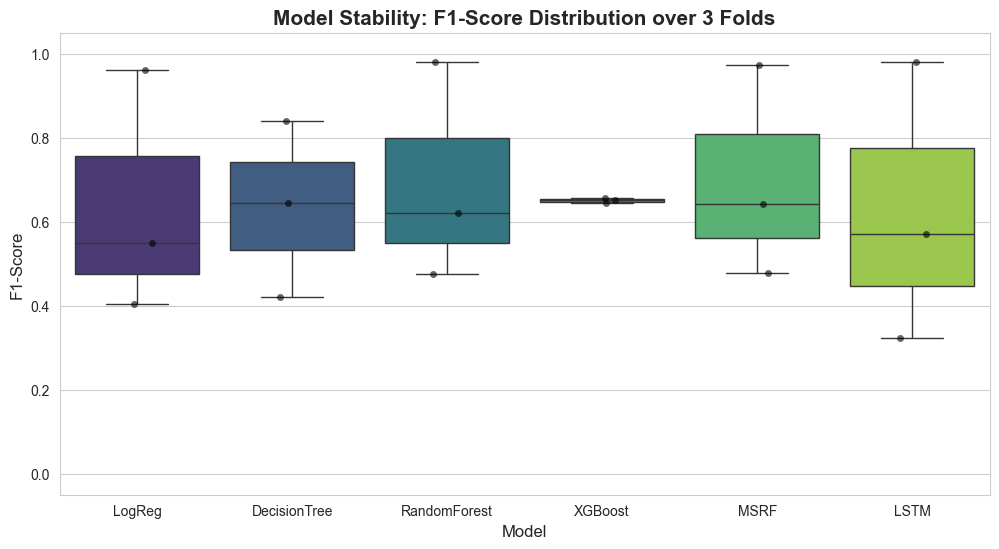

   > Saved F1-Score plot to: stability_boxplot_F1Score.png


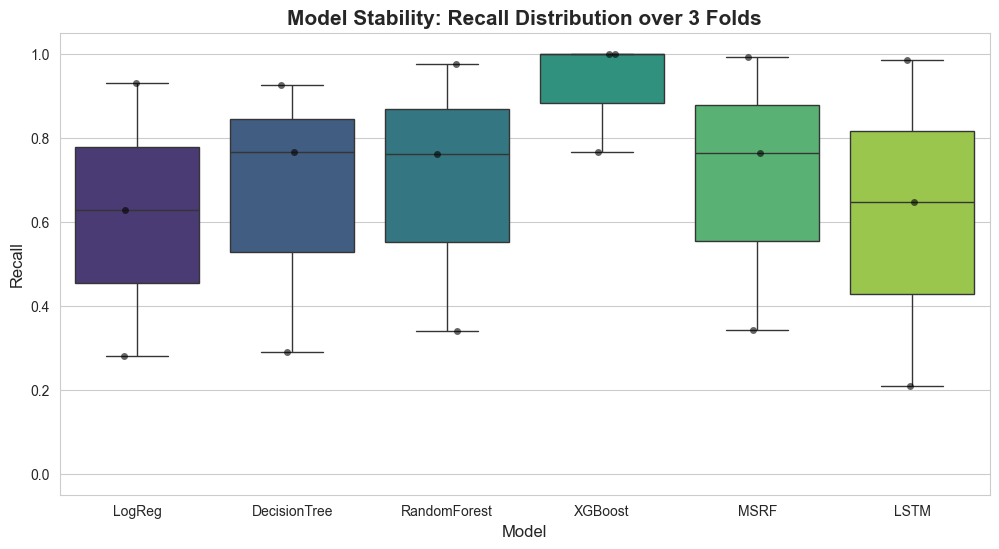

   > Saved Recall plot to: stability_boxplot_Recall.png


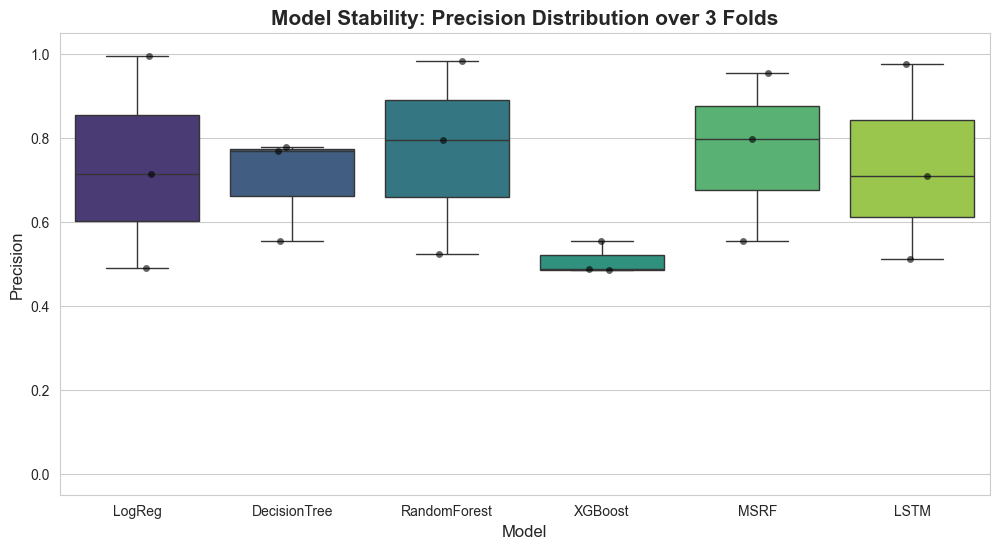

   > Saved Precision plot to: stability_boxplot_Precision.png


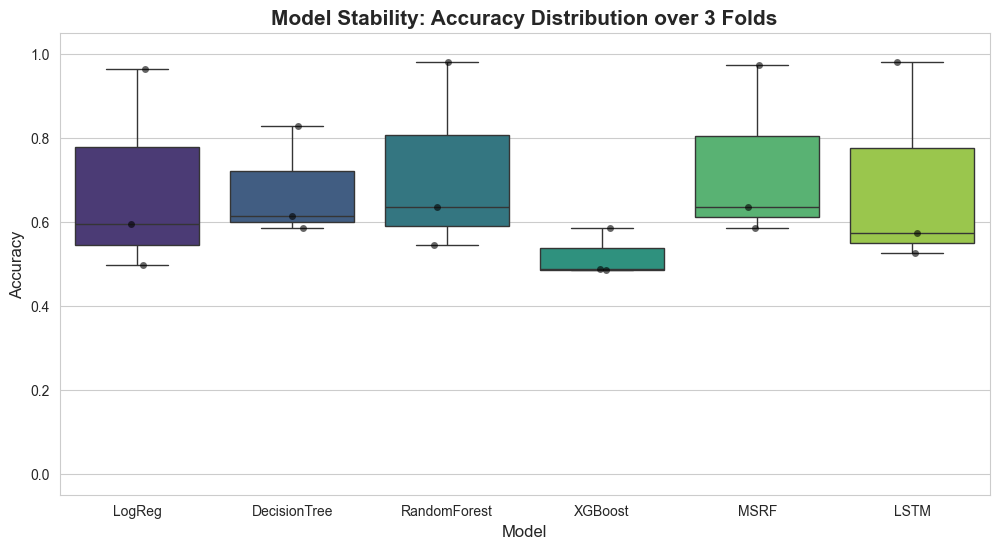

   > Saved Accuracy plot to: stability_boxplot_Accuracy.png


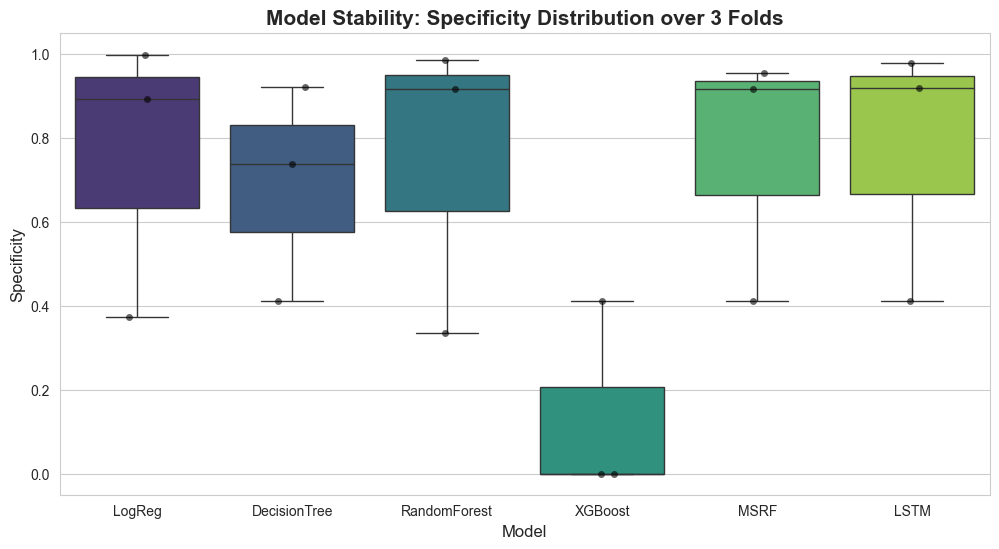

   > Saved Specificity plot to: stability_boxplot_Specificity.png


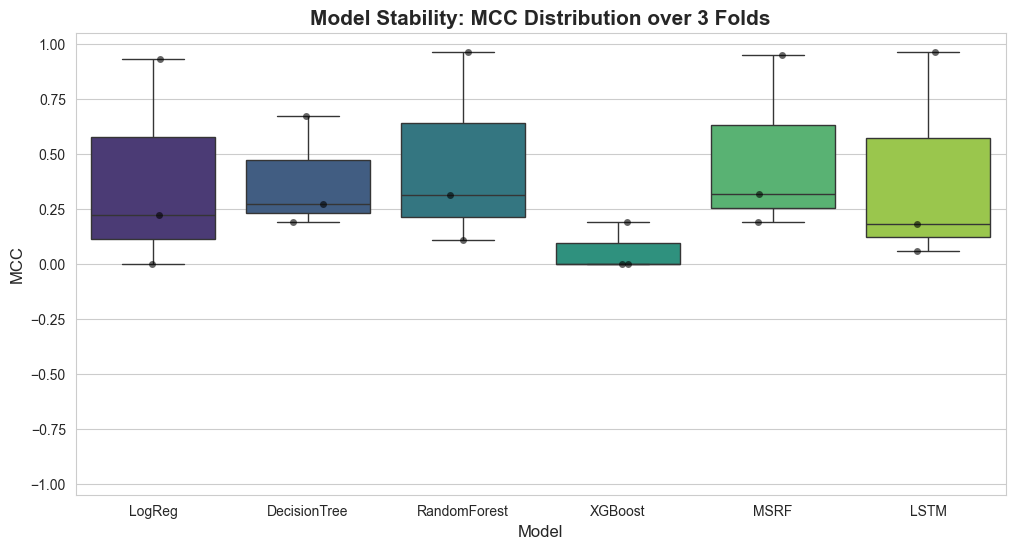

   > Saved MCC plot to: stability_boxplot_MCC.png


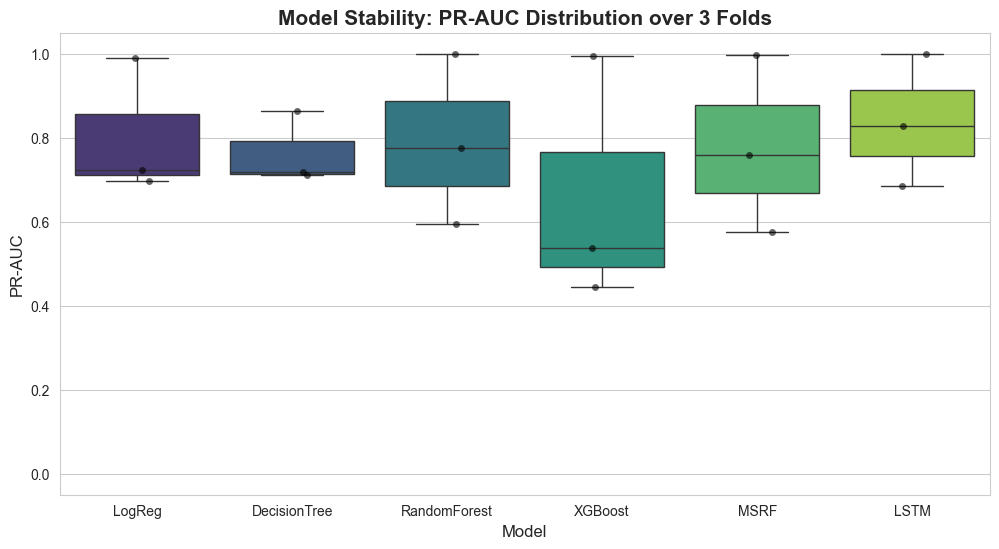

   > Saved PR-AUC plot to: stability_boxplot_PRAUC.png


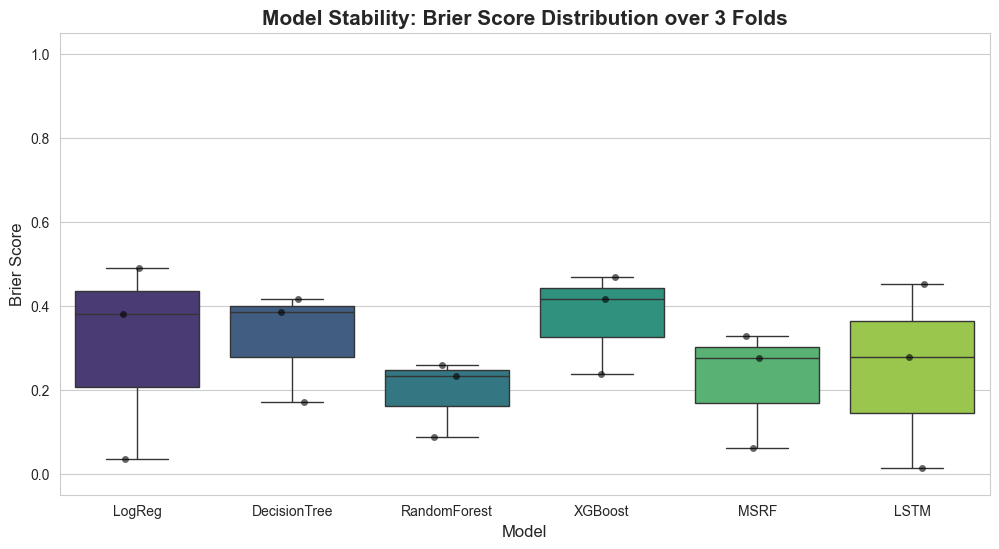

   > Saved Brier Score plot to: stability_boxplot_Brier_Score.png
[DONE] All metric boxplots saved in: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\Metric_Distributions


In [ ]:
print("\n--- Generating Metric Distribution Visualizations ---")
sns.set_style("whitegrid")

# Create a dedicated sub-folder for these plots
boxplot_dir = os.path.join(output_dir, "Metric_Distributions")
os.makedirs(boxplot_dir, exist_ok=True)
print(f"Created directory for boxplots: {boxplot_dir}")

metrics_to_plot = ["F1-Score", "Recall", "Precision", "Accuracy", "Specificity", "MCC", "PR-AUC", "Brier Score"]

for metric in metrics_to_plot:
    if metric not in df_all.columns:
        print(f"Skipping {metric}: Not found in dataframe columns.")
        continue

    plt.figure(figsize=(12, 6))
    
    # Create the Box Plot
    sns.boxplot(x="Model", y=metric, data=df_all, palette="viridis", showfliers=False)
    
    # Overlay the Strip Plot
    sns.stripplot(x="Model", y=metric, data=df_all, color='black', alpha=0.6, jitter=True)
    
    plt.title(f"Model Stability: {metric} Distribution over {N_FOLDS} Folds", fontsize=15, fontweight='bold')
    plt.ylabel(metric, fontsize=12)
    plt.xlabel("Model", fontsize=12)
    
    # Set y-axis limits to 0-1 for standard metrics (MCC is -1 to 1)
    if metric != "MCC":
        plt.ylim(-0.05, 1.05)
    else:
        plt.ylim(-1.05, 1.05)

    # Save
    safe_metric_name = metric.replace(" ", "_").replace("-", "")
    fname = f"stability_boxplot_{safe_metric_name}.png"
    save_path = os.path.join(boxplot_dir, fname)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"   > Saved {metric} plot to: {fname}")

print(f"[DONE] All metric boxplots saved in: {boxplot_dir}")


--- Generating Diagnostic Visualizations ---


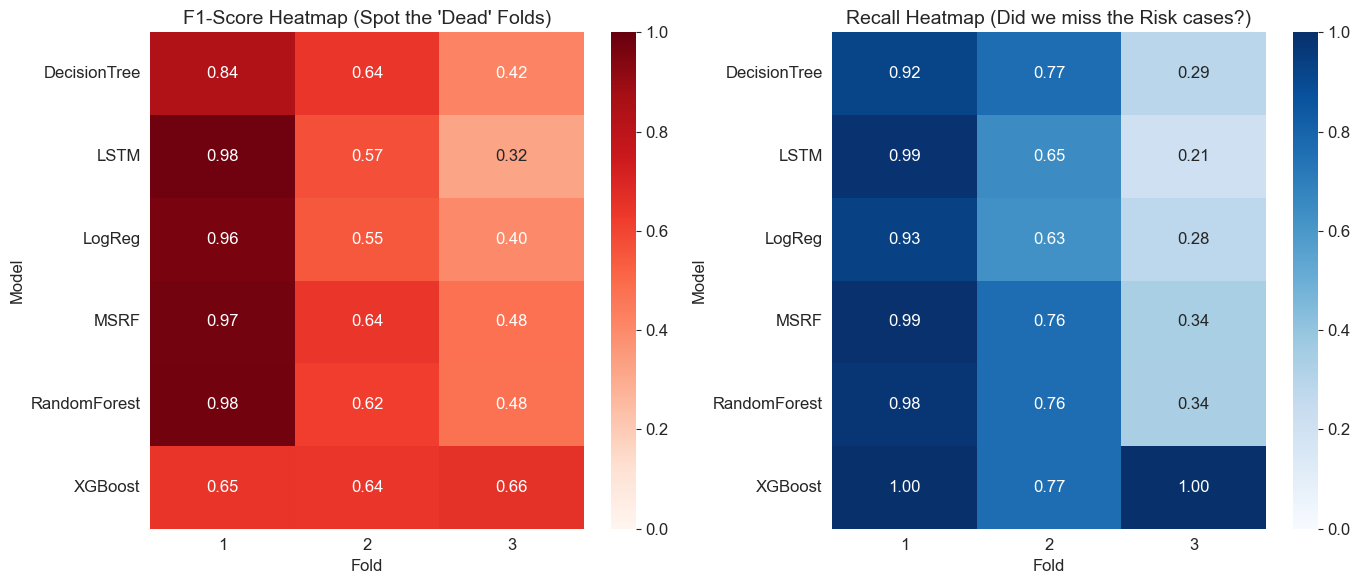

[SAVED] Fold Failure Analysis: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\fold_failure_analysis.png


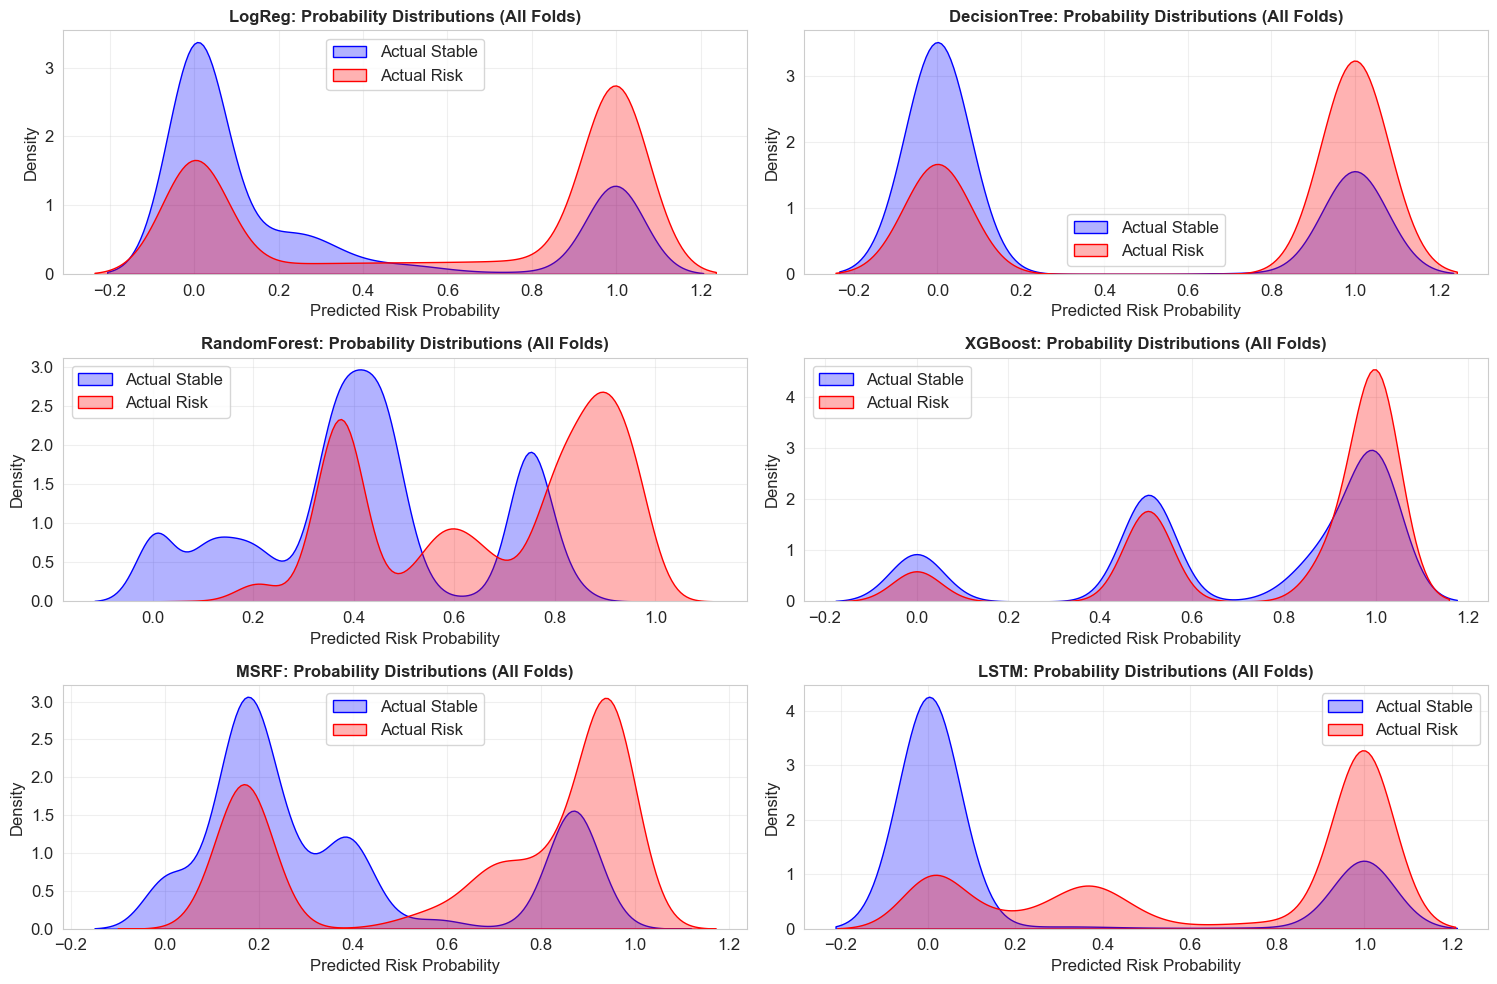

[SAVED] Probability distributions: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\probability_overlap.png


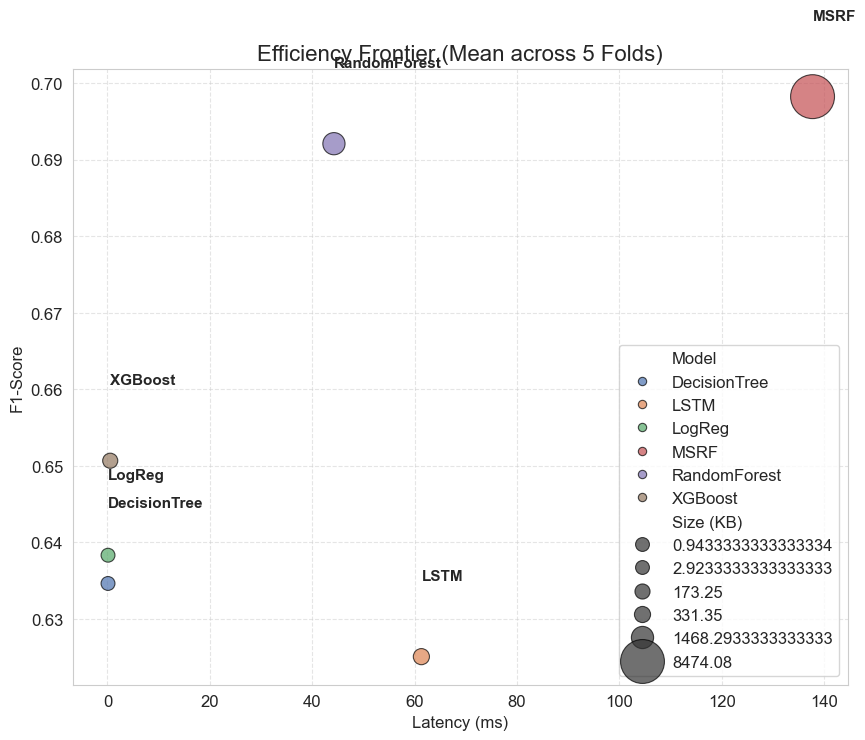

In [ ]:
# ==========================================
# DIAGNOSTIC VISUALIZATIONS
# ==========================================
print("\n--- Generating Diagnostic Visualizations ---")
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(14, 6))

# Subplot 1: F1-Score per Fold (Heatmap)
# This highlights exactly which fold failed for which model
plt.subplot(1, 2, 1)
pivot_f1 = df_all.pivot(index="Model", columns="Fold", values="F1-Score")
sns.heatmap(pivot_f1, annot=True, cmap="Reds", fmt=".2f", vmin=0, vmax=1)
plt.title("F1-Score Heatmap (Spot the 'Dead' Folds)", fontsize=14)

# Subplot 2: Threshold variance
plt.subplot(1, 2, 2)
pivot_rec = df_all.pivot(index="Model", columns="Fold", values="Recall")
sns.heatmap(pivot_rec, annot=True, cmap="Blues", fmt=".2f", vmin=0, vmax=1)
plt.title("Recall Heatmap (Did we miss the Risk cases?)", fontsize=14)

plt.tight_layout()
img_path = os.path.join(output_dir, "fold_failure_analysis.png")
plt.savefig(img_path, dpi=300)
plt.show()
print(f"[SAVED] Fold Failure Analysis: {img_path}")


# --- VIZ 2: probability calibration
# This plot checks if the model is confident but wrong, or just unsure.

plt.figure(figsize=(15, 10))
num_models = len(raw_results)
rows = math.ceil(num_models / 2)

for i, (name, data) in enumerate(raw_results.items()):
    if len(data['y_prob']) == 0: continue
    
    plt.subplot(rows, 2, i+1)
    
    # Separate probabilities by true class
    probs = np.array(data['y_prob'])
    trues = np.array(data['y_true'])
    
    sns.kdeplot(probs[trues==0], fill=True, color='blue', label='Actual Stable', alpha=0.3)
    sns.kdeplot(probs[trues==1], fill=True, color='red', label='Actual Risk', alpha=0.3)
    
    plt.title(f"{name}: Probability Distributions (All Folds)", fontsize=12, fontweight='bold')
    plt.xlabel("Predicted Risk Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
img_path = os.path.join(output_dir, "probability_overlap.png")
plt.savefig(img_path, dpi=300)
plt.show()
print(f"[SAVED] Probability distributions: {img_path}")

# --- VIZ 3: efficiency bubble plot
plt.figure(figsize=(10, 8))
plot_df = df_all.groupby("Model")[["F1-Score", "Latency (ms)", "Size (KB)"]].mean().reset_index()

sns.scatterplot(
    data=plot_df, x="Latency (ms)", y="F1-Score", size="Size (KB)", 
    sizes=(100, 1000), hue="Model", palette="deep", alpha=0.7, edgecolor="black"
)

for i in range(plot_df.shape[0]):
    plt.text(plot_df["Latency (ms)"][i], plot_df["F1-Score"][i]+0.01, 
             plot_df["Model"][i], fontsize=11, weight='bold')

plt.title("Efficiency Frontier (Mean across 5 Folds)", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(os.path.join(output_dir, "efficiency_frontier.png"), dpi=300)
plt.show()


--- Generating Heatmap Dashboard ---


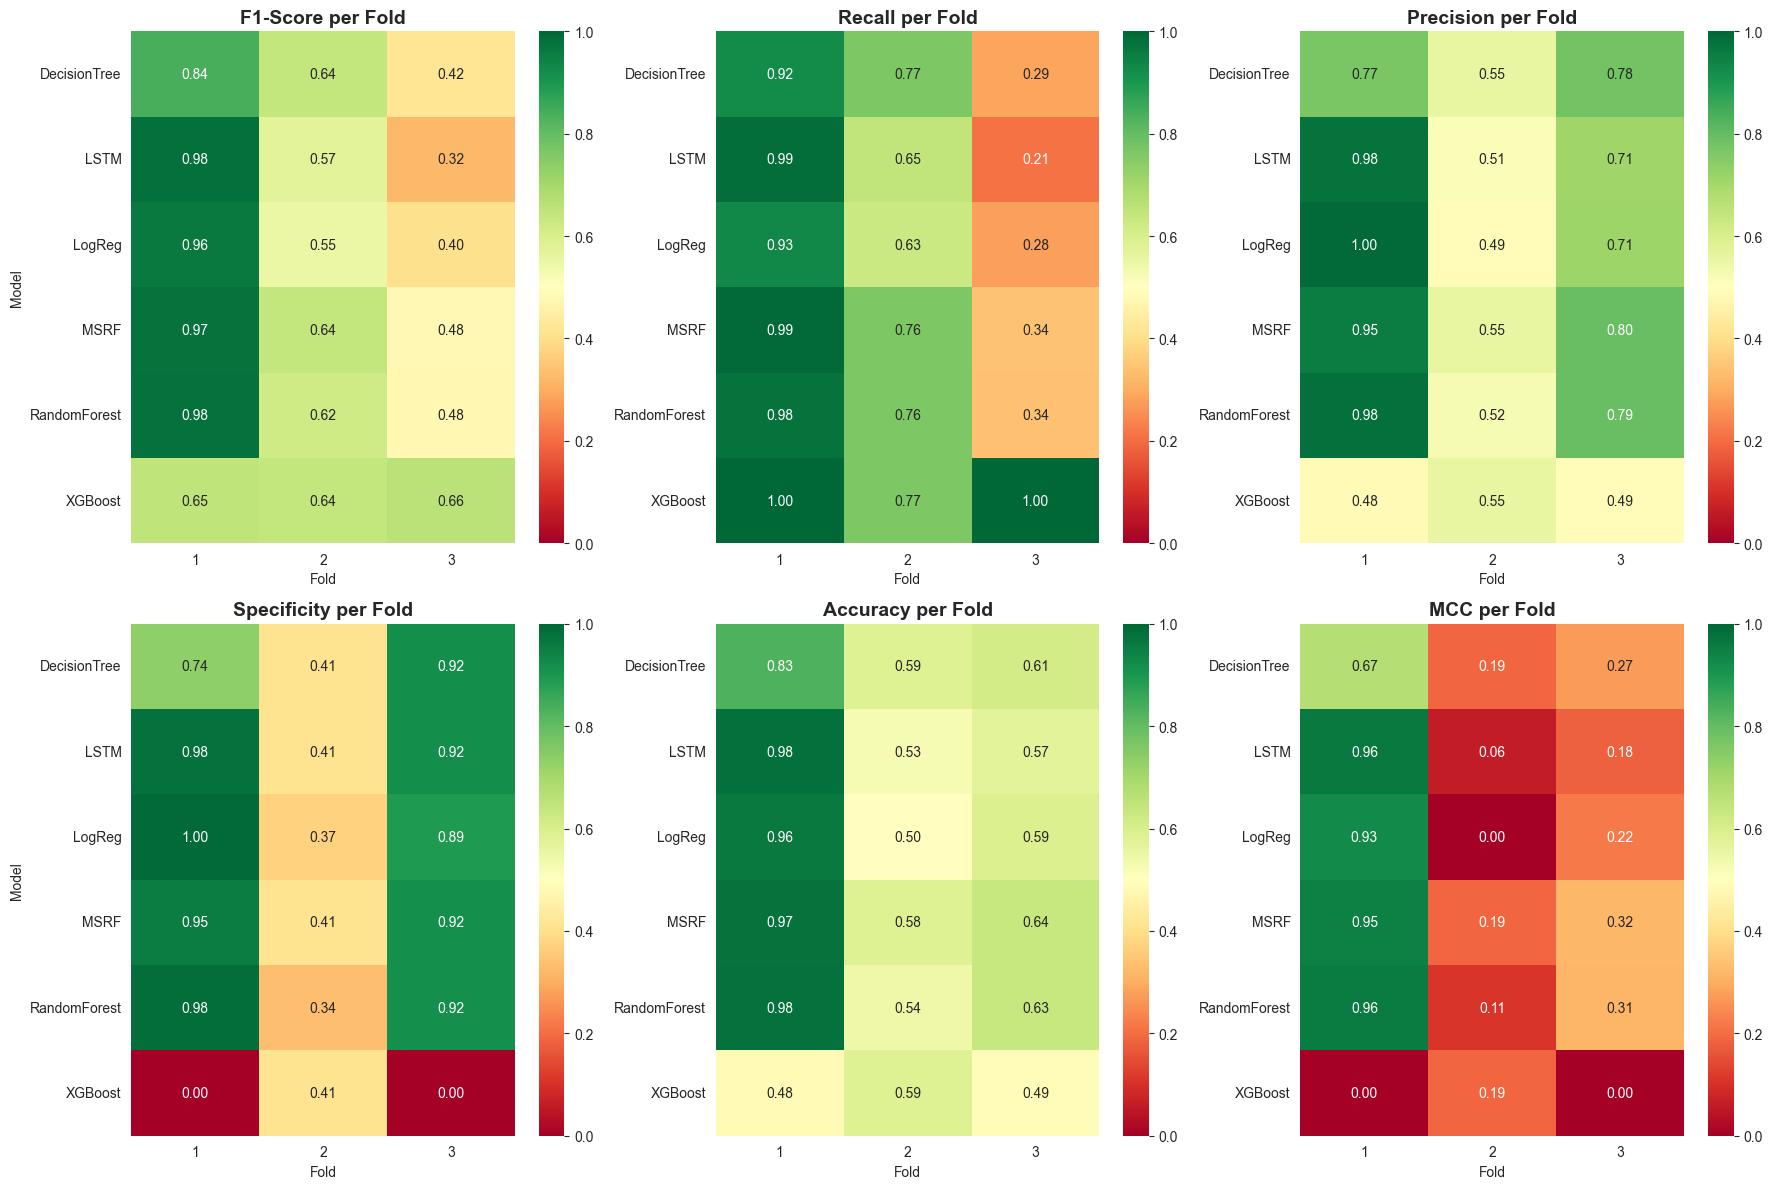

[SAVED] Dashboard Heatmap: Thesis_Experiments\Exp_01_Baseline\Run_2026-01-24_14-00-06_Win60_Stride30_SNR5_Tau2_Filter_band3.0_Modeconfidence_Restrict0\full_diagnostic_heatmaps.png


In [ ]:
import math

# ==========================================
# 5. DIAGNOSTIC VISUALIZATIONS (UPGRADED HEATMAPS)
# ==========================================
print("\n--- Generating Heatmap Dashboard ---")
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10}) # Slightly smaller font to fit everything

metrics_to_map = ["F1-Score", "Recall", "Precision", "Specificity", "Accuracy", "MCC"]

# Filter out metrics that don't exist in the dataframe to prevent errors
valid_metrics = [m for m in metrics_to_map if m in df_all.columns]
n_metrics = len(valid_metrics)

# 2. Calculate Grid Dimensions
cols = 3
rows = math.ceil(n_metrics / cols)

plt.figure(figsize=(18, 6 * rows))

for i, metric in enumerate(valid_metrics):
    plt.subplot(rows, cols, i + 1)
    
    # Create the Pivot Table for this specific metric
    pivot_data = df_all.pivot(index="Model", columns="Fold", values=metric)
    
    sns.heatmap(pivot_data, annot=True, cmap="RdYlGn", fmt=".2f", vmin=0, vmax=1)
    
    plt.title(f"{metric} per Fold", fontsize=14, fontweight='bold')
    plt.ylabel("Model" if i % cols == 0 else "")
    plt.xlabel("Fold")

plt.tight_layout()
img_path = os.path.join(output_dir, "full_diagnostic_heatmaps.png")
plt.savefig(img_path, dpi=300)
plt.show()

print(f"[SAVED] Dashboard Heatmap: {img_path}")

# Cell 7

In [ ]:
# ---------------------------------------------------------
# CELL 7: OPTIMIZATION & FINAL RESULTS
# ---------------------------------------------------------

log_file_path = os.path.join(output_dir, "execution_log_opt_thresh.txt")

class DualLogger(object):
    def __init__(self, filepath):
        self.terminal = sys.stdout
        # Mode 'a' (append) is CRITICAL here so we don't delete Cell 6's logs
        self.log = open(filepath, "a", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# Re-activate logging
sys.stdout = DualLogger(log_file_path)

if 'fold_results' in locals():
    df_all = pd.DataFrame(fold_results) 
else:
    # Fallback if variable missing, creates dummy efficiency data
    print("Warning: fold_results not found. Using dummy efficiency data.")
    df_all = pd.DataFrame({'Model': list(raw_results.keys()), 'Latency (ms)': 0, 'Size (KB)': 0, 'Inf RAM (KB)': 0})

print("\n" + "="*80)
print("POST-PROCESSING: High-Precision Threshold Optimization (0.001 Steps)")
print("="*80)

final_stats = []
threshold_curves = {} 

# Helper: Bootstrap Function
def bootstrap_metric(y_true, y_pred, metric_func, n_boot=1000):
    """Generates 95% Confidence Intervals via Bootstrapping"""
    scores = []
    indices = np.arange(len(y_true))
    if len(y_true) < 2: return 0.0, 0.0
    
    for _ in range(n_boot):
        boot_idx = np.random.choice(indices, len(indices), replace=True)
        score = metric_func(y_true[boot_idx], y_pred[boot_idx])
        scores.append(score)
    return np.percentile(scores, 2.5), np.percentile(scores, 97.5) # 95% CI

for name, data in raw_results.items():
    y_true = np.array(data['y_true'])
    y_prob = np.array(data['y_prob'])
    
    if len(y_true) == 0: continue
    thresholds = np.arange(0.001, 1.0, 0.001) 
    
    best_thresh = 0.5
    best_f1 = 0
    f1_scores_list = [] 
    
    for t in thresholds:
        pred_t = (y_prob >= t).astype(int)
        f1_t = f1_score(y_true, pred_t, zero_division=0)
        f1_scores_list.append(f1_t) 
        
        if f1_t > best_f1:
            best_f1 = f1_t
            best_thresh = t
            
    threshold_curves[name] = f1_scores_list 
            
    # Apply Best Threshold
    final_pred = (y_prob >= best_thresh).astype(int)
    
    # Calculate Metrics directly
    acc = accuracy_score(y_true, final_pred)
    prec = precision_score(y_true, final_pred, zero_division=0)
    rec = recall_score(y_true, final_pred, zero_division=0)
    f1 = f1_score(y_true, final_pred, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(y_true, final_pred, labels=[0,1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    mcc = matthews_corrcoef(y_true, final_pred)
    pr_auc = average_precision_score(y_true, y_prob)
    
    # Bootstrap F1-Score (95% CI)
    lower, upper = bootstrap_metric(y_true, final_pred, lambda yt, yp: f1_score(yt, yp, zero_division=0))
    
    # Get Efficiency Metrics
    try:
        eff_row = df_all[df_all['Model'] == name].iloc[0]
        lat = eff_row.get('Latency (ms)', eff_row.get('Latency', 0))
        size = eff_row.get('Size (KB)', eff_row.get('Size', 0))
        ram = eff_row.get('Inf RAM (KB)', eff_row.get('RAM', 0))
    except IndexError:
        lat, size, ram = 0, 0, 0
    
    stats = {
        "Model": name,
        "Opt_Thresh": best_thresh,
        "Accuracy": acc,
        "F1": f1,
        "F1_Low": lower,
        "F1_High": upper,
        "Recall": rec,
        "Precision": prec,
        "Specificity": spec,
        "MCC": mcc,
        "PR-AUC": pr_auc,
        "Latency": lat,
        "Size_KB": size,
        "RAM_KB": ram
    }
    final_stats.append(stats)

# Create Final DataFrame
final_df = pd.DataFrame(final_stats)
if not final_df.empty:
    final_df = final_df.sort_values(by="F1", ascending=False)

    cols = ["Model", "Opt_Thresh", "Accuracy", "F1", "F1_Low", "F1_High", 
            "Recall", "Precision", "Specificity", "MCC", "PR-AUC", 
            "Latency", "Size_KB", "RAM_KB"]
    
    print("\nFINAL METRICS SUMMARY:")
    print(final_df[cols].to_string(index=False, float_format="%.3f"))

    # Save CSV
    csv_path = os.path.join(output_dir, "optimized_results.csv")
    final_df[cols].to_csv(csv_path, index=False)
    print(f"\n[SAVED] Optimized metrics saved to: {csv_path}")
    
    # PLOT 0: Threshold vs F1-Score
    plt.figure(figsize=(12, 6))
    
    # Loop through items so we can capture the color object immediately
    for name, scores in threshold_curves.items():
        # Plot the line and capture the object
        line, = plt.plot(thresholds, scores, label=f"{name}") 
        c = line.get_color()
        
        # Find the optimal point for this specific model
        row = final_df[final_df['Model'] == name]
        if not row.empty:
            opt_t = row['Opt_Thresh'].values[0]
            opt_f = row['F1'].values[0]
            
            # Plot the dot using the SAME color 'c'
            plt.scatter(opt_t, opt_f, s=60, color=c, zorder=5, edgecolors='white', linewidth=1.5)
        
    plt.title("Optimization Curves: F1-Score vs. Decision Threshold")
    plt.xlabel("Decision Threshold")
    plt.ylabel("F1-Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
   
    # Save Plot 0
    plt.savefig(os.path.join(output_dir, "optimization_curves.png"))
    plt.show()

    # PLOT 1: Performance with Confidence Intervals
    plt.figure(figsize=(10, 6))
    yerr = [final_df['F1'] - final_df['F1_Low'], final_df['F1_High'] - final_df['F1']]
    sns.barplot(x='Model', y='F1', data=final_df, palette='viridis', capsize=0.1)
    plt.errorbar(x=range(len(final_df)), y=final_df['F1'], yerr=yerr, fmt='none', c='black', capsize=5)
    plt.title(f"Model F1-Score (Optimized Threshold) with 95% CI")
    plt.ylim(0, 1.0)
    plt.ylabel("F1 Score")
    
    # Save Plot 1
    plt.savefig(os.path.join(output_dir, "model_performance_ci.png"))
    plt.show()

    # PLOT 2: Confusion Matrices
    n_models = len(final_stats)
    cols = 3
    rows = math.ceil(n_models / cols)
    plt.figure(figsize=(15, 5 * rows))
    plt.suptitle("Confusion Matrices at OPTIMAL Thresholds", fontsize=16, y=0.95)

    for i, row in enumerate(final_stats):
        name = row['Model']
        thresh = row['Opt_Thresh']
        
        y_t = np.array(raw_results[name]['y_true'])
        y_p = (np.array(raw_results[name]['y_prob']) >= thresh).astype(int)
        
        plt.subplot(rows, cols, i + 1)
        cm = confusion_matrix(y_t, y_p, labels=[0, 1])
        
        group_names = ['True Stable','False Risk','False Stable (DANGER)','True Risk']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        total_cm = np.sum(cm)
        if total_cm > 0:
            group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/total_cm]
        else:
            group_percentages = ["0%", "0%", "0%", "0%"]
            
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        
        sns.heatmap(cm, annot=labels, fmt='', cmap='Reds', cbar=False)
        plt.title(f"{name} (Thresh={thresh:.3f})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save Plot 2
    plt.savefig(os.path.join(output_dir, "optimized_confusion_matrices.png"))
    plt.show()

    # PLOT 3: ROC Curves
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC=0.5)')

    for name, data in raw_results.items():
        y_true_roc = np.array(data['y_true'])
        y_prob_roc = np.array(data['y_prob'])
        
        # Check if we have valid data and at least two classes (to avoid errors)
        if len(y_true_roc) > 0 and len(np.unique(y_true_roc)) > 1:
            fpr, tpr, _ = roc_curve(y_true_roc, y_prob_roc)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.4f})")

    plt.title("ROC Curves (Post-Optimization Analysis)", fontsize=16)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Save Plot 3
    roc_path_opt = os.path.join(output_dir, "optimized_roc_curves.png")
    plt.savefig(roc_path_opt)
    plt.show()
    print(f"[SAVED] Optimized ROC Curves saved to: {roc_path_opt}")
else:
    print("No results to display.")


# END LOGGING
try:
    print("\n=== EXPERIMENT COMPLETE ===")
    sys.stdout.log.close()
    sys.stdout = sys.stdout.terminal
    print("Log file closed.")
except:
    pass


# Export sample data and labels for Flutter app
print("\n=== EXPORTING DATA FOR FLUTTER APP ===")

# Take first 1000 samples from the final fold's test data
n_samples = min(1000, len(X_test_sel))
sample_features = X_test_sel[:n_samples]
sample_labels = y_test[:n_samples]

# Create directories if they don't exist
import os
os.makedirs("assets/data", exist_ok=True) 
os.makedirs("assets/exports", exist_ok=True)

# Save features (input data for predictions)
np.savetxt('assets/data/sample_input.csv', sample_features, delimiter=',')

# Save labels (ground truth for validation)
np.savetxt('assets/exports/labels.csv', sample_labels, delimiter=',', fmt='%d')

print(f"[SAVED] {n_samples} sample features → assets/data/sample_input.csv")
print(f"[SAVED] {n_samples} sample labels → assets/exports/labels.csv")
print(f"Labels distribution: {np.bincount(sample_labels.astype(int))}")
print("=== EXPORT COMPLETE ===")

# Verify the data
print(f"\nVerification:")
print(f"Features shape: {sample_features.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Labels range: {sample_labels.min()} to {sample_labels.max()}")


NameError: name 'os' is not defined